# Test set

Want to generate test set that can consistently be used across all models. This test set will therefore have only people diagnosed post-2010, and people with genetic data.

Things to try on the test set:
1. Age-only model
2. Genetic model
3. Model 1A
4. Model 1B
5. Model 1C
6. Model 2A
7. Model 2B
8. Model 3A
9. Model 3B

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from collections import Counter
from matplotlib_venn import venn2, venn3
from scipy import stats
from tableone import TableOne
import statsmodels.api as sm
from bs4 import BeautifulSoup
import re
import seaborn as sns
import scipy
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_auc_score
warnings.simplefilter('ignore')
import time
import scipy.sparse
from joblib import dump, load
import statsmodels
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

/home/cmay091/miniforge3/lib/python3.9/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/cmay091/miniforge3/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/cmay091/miniforge3/lib/python3.9/site-packages/sklearn/utils/multiclass.py:14: DeprecationWarning: Please use `spmatrix` from the `scipy.sparse` namespace, the `scipy.sparse.base` namespace is deprecated.
  from scipy.sparse.base import spmatrix
/home/cmay091/miniforge3/lib/python3.9/site-packages/sklearn/utils/optimize.py:18: DeprecationWarning: Please use `line_search_wolfe2` from the `scipy.optimize` namespace, the `scipy.optimize.linesearch` namespace is deprecated.
  from scipy.optimize.linesearch import line_search_wolfe2, line_search_wolfe1
/home/cmay091/

In [2]:
import shap

In [3]:
UKBB_PATH = '../glaucoma_project/UKBB_Data/'
MAIN_UKBB_FILE = '../glaucoma_project/UKBB_Data/ukb49508.tab'
SECOND_UKBB_FILE = '../glaucoma_project/UKBB_Data_Basket3/ukb51745.tab'
MAIN_HTML_FILE = '../glaucoma_project/UKBB_Data/ukb49508.html'
SECOND_HTML_FILE = '../glaucoma_project/UKBB_Data_Basket3/ukb51745.html'
TOTAL_POP = 502419
TEST_SET_RANDOM_SPLIT = 42
CHUNK_SIZE = 10000

# Creating test set

In [43]:
train_idx, test_idx = train_test_split(range(TOTAL_POP),random_state=TEST_SET_RANDOM_SPLIT, test_size=0.1)

In [44]:
len(test_idx)

50242

In [5]:
def get_dataframe_for_analysis(column_names, idx=test_idx):
    print('Preparing dataframe...')
    
    cols_in_main_file = pd.read_csv(MAIN_UKBB_FILE, sep='\t', nrows=1).columns
    cols_in_second_file = pd.read_csv(SECOND_UKBB_FILE, sep='\t', nrows=1).columns
    column_names_main = [col for col in column_names if col in cols_in_main_file]
    column_names_second = [col for col in column_names if (not col in cols_in_main_file) and (col in cols_in_second_file)]
    
    
    df_selected_cols = pd.DataFrame()
    for chunk in tqdm(pd.read_csv(MAIN_UKBB_FILE, sep='\t', chunksize=CHUNK_SIZE, usecols=column_names_main+['f.eid']), total=TOTAL_POP // CHUNK_SIZE):
        df_selected_cols = pd.concat([df_selected_cols, chunk])
        
    df_selected_cols_second = pd.DataFrame()
    for chunk in tqdm(pd.read_csv(SECOND_UKBB_FILE, sep='\t', chunksize=CHUNK_SIZE, usecols=column_names_second+['f.eid']), total=TOTAL_POP // CHUNK_SIZE):
        df_selected_cols_second = pd.concat([df_selected_cols_second, chunk])
    
    return pd.merge(df_selected_cols,df_selected_cols_second,how='left',on='f.eid').iloc[idx].reset_index(drop=True)

# Helpful code for field ids

In [18]:
file = open(MAIN_HTML_FILE, 'r', encoding='latin-1')
html_file = file.read()
soup = BeautifulSoup(html_file, "html.parser")
tables = soup.find_all('table')
rows_main = tables[1].find_all('tr')
file = open(SECOND_HTML_FILE, 'r', encoding='latin-1')
html_file = file.read()
soup = BeautifulSoup(html_file, "html.parser")
tables = soup.find_all('table')
rows_second = tables[1].find_all('tr')
rows = rows_main + rows_second

In [19]:
df_fields = pd.DataFrame()
fields = []
count = []
types = []
desc = []
current_type = None
current_desc = None
for row in rows:
    row_content = row.find_all('td')
    if len(row_content) > 2:
        fields.append(row_content[1].text.strip())
        count.append(row_content[2].text.strip())
        if len(row_content) > 4:
            current_type = row_content[3].text.strip()
            current_desc = row_content[4].text.strip()
        types.append(current_type)
        desc.append(current_desc)
        
df_fields['UDI'] = fields
df_fields['Count'] = [int(n) for n in count]
df_fields['Type'] = types
df_fields['Desc'] = desc
df_fields['Dating coding'] = df_fields['Desc'].apply(lambda x: re.sub('[^0-9]','', x[x.index('data-coding '):x.index(' comprises')]) if 'data-coding' in x else np.nan)
df_fields['Valued members'] = df_fields['Desc'].apply(lambda x: int(re.sub('[^0-9]','', x[x.index('comprises '):x.index('valued members')])) if 'data-coding' in x else np.nan)
df_fields['Field ID'] = df_fields['UDI'].apply(lambda x: 'f.'+re.sub('-','.',x))
df_fields['Desc Short'] = df_fields['Desc'].apply(lambda x: x[0:x.index('Uses data-coding')] if 'Uses data-coding' in x else x)

In [20]:
desc_unique = []
prev_desc = None
counter = 0
for desc in df_fields['Desc Short']:
    if prev_desc == desc:
        if counter == 0:
            desc_unique[-1] = desc+'_0'
        counter += 1
        desc_unique.append(desc+'_'+str(counter))
    else:
        counter = 0
        prev_desc = desc
        desc_unique.append(desc)
df_fields['Desc Unique'] = desc_unique

In [21]:
# Field ID to description 
id_to_desc = {id_:desc for id_,desc in zip(df_fields['Field ID'], df_fields['Desc Unique'])}
# Description to field ID
desc_to_id = {desc:id_ for desc,id_ in zip(df_fields['Desc Unique'], df_fields['Field ID'])}
# Field ID to field type
id_to_type = {id_:type_ for id_,type_ in zip(df_fields['Field ID'], df_fields['Type'])}

In [22]:
df_fields = df_fields.drop_duplicates('UDI').reset_index(drop=True)

In [23]:
coding_dicts = []
for df_coding in [pd.read_csv(UKBB_PATH+'UKBB_encodings/coding19.tsv', sep='\t'),
                  pd.read_csv(UKBB_PATH+'UKBB_encodings/coding3.tsv', sep='\t'),
                  pd.read_csv(UKBB_PATH+'UKBB_encodings/coding6.tsv', sep='\t'),
                  pd.read_csv(UKBB_PATH+'UKBB_encodings/coding4.tsv', sep='\t')]:
    coding_dicts.append({code:meaning for code,meaning in zip(df_coding['coding'], df_coding['meaning'])})

In [24]:
def feature_id_to_name(feature_id):
    if 'f.' in feature_id:
        if '_' in feature_id:
            return id_to_desc[feature_id[:feature_id.find('_')]] + feature_id[feature_id.find('_'):]
        else:
            return id_to_desc[feature_id]
    if 'ICD_10_' in feature_id:
        return coding_dicts[0][feature_id[7:]]
    if 'Self_Report_' in feature_id:
        return coding_dicts[2][int(feature_id[12:-2])]
    if 'Cancer_' in feature_id:
        return coding_dicts[1][int(feature_id[7:-2])]
    if 'Med_' in feature_id:
        return coding_dicts[3][int(feature_id[4:-2])]
    return 'FEATURE NOT FOUND'

# Defining Glaucoma

Defining glaucoma as per MacGregor (2018)

Using the following columns:
- Non-cancer illness code, self-reported (20002)
- Diagnoses - ICD10 (41270)
- Diagnoses - ICD9 (41271)
- Eye problems/disorders (6148) via touchscreen

In [21]:
glaucoma_diagnosis_columns = [column for column in df_fields['Field ID'] if '20002' in column or '41270' in column or '41271' in column or '6148' in column]

In [22]:
touchscreen_cols = [id_to_desc[col] for col in glaucoma_diagnosis_columns if '6148' in col]
self_reported_cols = [id_to_desc[col] for col in glaucoma_diagnosis_columns if '20002' in col]
icd10_cols = [id_to_desc[col] for col in glaucoma_diagnosis_columns if '41270' in col]
icd9_cols = [id_to_desc[col] for col in glaucoma_diagnosis_columns if '41271' in col]

In [23]:
df_glaucoma_data = get_dataframe_for_analysis(glaucoma_diagnosis_columns)

Preparing dataframe...


51it [09:09, 10.77s/it]                                                                                                       
51it [00:49,  1.03it/s]                                                                                                       


Rename columns to be more descriptive

In [24]:
df_glaucoma_data.columns = [id_to_desc[column] for column in df_glaucoma_data.columns]

Method to see if a particular diagnosis is present in a set of columns.
- codes: the code to look for
- key_word: filter columns by this keyword when looking for codes
- df_columns: the relevant dataset

Will output one column for each code requested

In [25]:
def patient_has_diagnosis(codes,key_word, df_columns):
    # get only the columns that have key_word in them (e.g. selected ICD10 diagnoses only)
    diagnoses_columns = [column for column in df_columns.columns if key_word in column]
    df_relevant_columns = df_columns[diagnoses_columns]
    
    # each column in this correspond to columns in df_relevant_columns, saying which codes are present
    df_codes_present = pd.DataFrame()
    
    for column in tqdm(diagnoses_columns):
        df_codes_present[column] = df_relevant_columns[column].apply(lambda x: [code in str(x) for code in codes])
    
    # columns in this correspond to codes - whether or not codes are present
    df_output_columns = pd.DataFrame()
    for i in tqdm(range(len(codes))):
        df_output_columns[codes[i]] = [False]*len(df_columns)
        for column in df_codes_present.columns:
            df_output_columns[codes[i]] = df_output_columns[codes[i]] | df_codes_present[column].apply(lambda x: x[i])
            
    return df_output_columns

Extract ICD10 information

In [26]:
icd10_column_names = ['ICD10 POAG','ICD10 Other glaucoma','ICD10 Glaucoma unspecified']
icd10_codes = ['H401','H408','H409']

In [27]:
df_icd_10 = patient_has_diagnosis(icd10_codes,'Diagnoses - ICD10',df_glaucoma_data)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.93s/it]


In [28]:
for column_name, code in zip(icd10_column_names, icd10_codes):
    df_glaucoma_data[column_name] = df_icd_10[code]
    print(df_glaucoma_data[column_name].value_counts())

False    49906
True       336
Name: ICD10 POAG, dtype: int64
False    50220
True        22
Name: ICD10 Other glaucoma, dtype: int64
False    49465
True       777
Name: ICD10 Glaucoma unspecified, dtype: int64


Extract ICD9 information

In [29]:
icd9_column_names = ['ICD9 POAG', 'ICD9 Other glaucoma','ICD9 Glaucoma unspecified']
icd9_codes = ['3651','3658','3659']

In [30]:
df_icd_9 = patient_has_diagnosis(icd9_codes,'Diagnoses - ICD9',df_glaucoma_data)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.35it/s]


In [31]:
for column_name, code in zip(icd9_column_names, icd9_codes):
    df_glaucoma_data[column_name] = df_icd_9[code]
    print(df_glaucoma_data[column_name].value_counts())

False    50241
True         1
Name: ICD9 POAG, dtype: int64
False    50242
Name: ICD9 Other glaucoma, dtype: int64
False    50239
True         3
Name: ICD9 Glaucoma unspecified, dtype: int64


Extract self-reported glaucoma information

In [32]:
df_glaucoma_data['Self-reported glaucoma 1'] = patient_has_diagnosis(['1277'],'Non-cancer illness code, self-reported',df_glaucoma_data)['1277']

100%|███████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.19s/it]


In [33]:
df_glaucoma_data['Self-reported glaucoma 1'].value_counts()

False    49636
True       606
Name: Self-reported glaucoma 1, dtype: int64

In [34]:
df_glaucoma_data['Self-reported glaucoma 2'] = ((df_glaucoma_data['Eye problems/disorders_0'] == 2) | (df_glaucoma_data['Eye problems/disorders_1'] == 2)
| (df_glaucoma_data['Eye problems/disorders_2'] == 2) | (df_glaucoma_data['Eye problems/disorders_3'] == 2)
| (df_glaucoma_data['Eye problems/disorders_4'] == 2))

In [35]:
df_glaucoma_data['Self-reported glaucoma 2'].value_counts()

False    49515
True       727
Name: Self-reported glaucoma 2, dtype: int64

Combining it all together...

In [37]:
df_glaucoma_data['Total Glaucoma'] = df_glaucoma_data['ICD10 POAG'] | df_glaucoma_data['ICD10 Other glaucoma'] | df_glaucoma_data['ICD10 Glaucoma unspecified'] | df_glaucoma_data['Self-reported glaucoma 1'] | df_glaucoma_data['Self-reported glaucoma 2'] | df_glaucoma_data['ICD9 POAG'] | df_glaucoma_data['ICD9 Other glaucoma'] | df_glaucoma_data['ICD9 Glaucoma unspecified']

In [39]:
df_glaucoma_data['Total Glaucoma'].value_counts()

False    48847
True      1395
Name: Total Glaucoma, dtype: int64

In [40]:
df_glaucoma_data['Total Glaucoma'].value_counts(normalize=True)

False    0.972234
True     0.027766
Name: Total Glaucoma, dtype: float64

# Getting earliest year of glaucoma diagnosis

Getting the earliest year of glaucoma diagnosis.
This allows us to exclude diagnoses and events that happen before the glaucoma diagnosis, minimising the possibility that reverse causation is causing an association.

Using the following columns:
- 4689 (age glaucoma diagnosed - touchscreen)
- 34 (year of birth - for year calculation)
- 20008 (year of self-reported)
- 41280 (date of diagnosis ICD10)
- 41281 (date of diagnosis ICD9)


In [41]:
year_of_diagnosis_columns = [column for column in df_fields['Field ID'] if '20008' in column or '41280' in column or '41281' in column or '4689' in column or column == 'f.34.0.0']

In [42]:
touchscreen_cols_date = [col for col in year_of_diagnosis_columns if '4689' in col]
self_reported_cols_date = [col for col in year_of_diagnosis_columns if '20008' in col]
icd10_cols_date = [col for col in year_of_diagnosis_columns if '41280' in col]
icd9_cols_date = [col for col in year_of_diagnosis_columns if '41281' in col]

In [43]:
df_date_data = get_dataframe_for_analysis(year_of_diagnosis_columns)

Preparing dataframe...


51it [09:59, 11.75s/it]                                                                                                       
51it [00:57,  1.12s/it]                                                                                                       


Determine the earliest date of glaucoma diagnosis

In [44]:
earliest_date = []

for i in tqdm(range(len(df_glaucoma_data))):
    if df_glaucoma_data.iloc[i]['Total Glaucoma']:
        earliest_year_list = []

        earliest_year_list.append(df_date_data.iloc[i][touchscreen_cols_date].min() + df_date_data.iloc[i]['f.34.0.0'])

        prospective_years = pd.Series((df_glaucoma_data.iloc[i][self_reported_cols] == 1277).astype(int).values * df_date_data.iloc[i][self_reported_cols_date].values)
        earliest_year_list.append(prospective_years.apply(lambda x: np.nan if x < 1900 else x).min())

        prospective_years = pd.Series(df_glaucoma_data.iloc[i][icd10_cols].apply(lambda x: x in icd10_codes).astype(int).values * df_date_data.iloc[i][icd10_cols_date].apply(lambda x: x if pd.isna(x) else int(x.split('-')[0])).values)
        earliest_year_list.append(prospective_years.apply(lambda x: np.nan if x < 1900 else x).min())

        prospective_years = pd.Series(df_glaucoma_data.iloc[i][icd9_cols].apply(lambda x: x in icd9_codes).astype(int).values * df_date_data.iloc[i][icd9_cols_date].apply(lambda x: x if pd.isna(x) else int(x.split('-')[0])).values)
        earliest_year_list.append(prospective_years.apply(lambda x: np.nan if x < 1900 else x).min())

        earliest_year_list = [year for year in earliest_year_list if not pd.isna(year)]
        if len(earliest_year_list) > 0:
            earliest_date.append(min(earliest_year_list))
        else:
            earliest_date.append(np.nan)
    else:
        earliest_date.append(np.nan)

100%|█████████████████████████████████████████████████████████████████████████████████| 50242/50242 [00:33<00:00, 1508.37it/s]


In [46]:
df_glaucoma_data['Diagnosis Year'] = earliest_date

<AxesSubplot:>

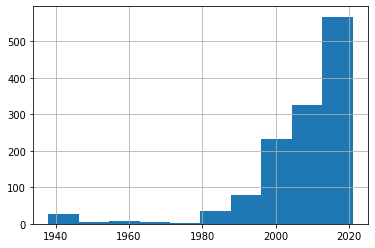

In [47]:
df_glaucoma_data['Diagnosis Year'].hist()

In [48]:
df_glaucoma_data[df_glaucoma_data['Total Glaucoma']]['Diagnosis Year'].isna().value_counts()

False    1287
True      108
Name: Diagnosis Year, dtype: int64

In [49]:
df_glaucoma_data.to_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/glaucoma_data_checkpoint_test.pkl')

In [50]:
df_glaucoma_data = pd.read_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/glaucoma_data_checkpoint_test.pkl')

In [51]:
df_date_data.to_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/date_data_checkpoint_test.pkl')

# Expanding columns into matrices

Certain features (e.g. ICD10 codes) span multiple columns, and would be better processed as a matrix with each column being the possible values of the feature

Does some linear algebra to multiply matrices and make everything fit together nicely

In [9]:
def get_binary_encoding_of_columns_combined_matrix(matrix_1, matrix_2):
    cols_1 = matrix_1.columns
    cols_2 = matrix_2.columns
    combined_list = pd.Series(sorted(list(set(cols_1).union(set(cols_2)))))
    encoding_1 = combined_list.apply(lambda x: 1 if x in cols_1 else 0)
    encoding_2 = combined_list.apply(lambda x: 1 if x in cols_2 else 0)
    return combined_list, encoding_1, encoding_2

In [10]:
def build_matrix_from_encodings(encoding):
    encoding_sum = encoding.sum()
    ident = np.identity(encoding_sum)
    final_matrix = []
    for item in encoding:
        if item == 1:
            final_matrix.append(ident[0])
            ident = ident[1:]
        else:
            final_matrix.append(np.zeros(encoding_sum))
    return scipy.sparse.coo_matrix(np.asarray(final_matrix).T)

In [11]:
def combine_matrices(matrix_1, matrix_2):
    if matrix_1 is None:
        return matrix_2
    combined_list, encoding_1, encoding_2 = get_binary_encoding_of_columns_combined_matrix(matrix_1, matrix_2)
    mult_matrix_1 = build_matrix_from_encodings(encoding_1)
    mult_matrix_2 = build_matrix_from_encodings(encoding_2)
    combined_matrix = matrix_1.sparse.to_coo() * mult_matrix_1 + matrix_2.sparse.to_coo() * mult_matrix_2
    df = pd.DataFrame.sparse.from_spmatrix(combined_matrix)
    df.columns = combined_list
    return df

In [12]:
def expand_matrix(df):
    current_matrix = None
    for column in tqdm(df.columns):
        matrix_to_add = pd.get_dummies(df[column],sparse=True)
        current_matrix = combine_matrices(current_matrix,matrix_to_add)
    return current_matrix

## ICD10 diagnoses

In [56]:
df_diagnoses = df_glaucoma_data[icd10_cols].copy()
df_diagnoses_dates = df_date_data[icd10_cols_date]

In [57]:
df_glaucoma_data[df_glaucoma_data['Total Glaucoma']]

,Encoded anonymised participant ID,Eye problems/disorders_0,Eye problems/disorders_1,Eye problems/disorders_2,Eye problems/disorders_3,Eye problems/disorders_4,Eye problems/disorders_5,Eye problems/disorders_6,Eye problems/disorders_7,Eye problems/disorders_8,...,ICD10 POAG,ICD10 Other glaucoma,ICD10 Glaucoma unspecified,ICD9 POAG,ICD9 Other glaucoma,ICD9 Glaucoma unspecified,Self-reported glaucoma 1,Self-reported glaucoma 2,Total Glaucoma,Diagnosis Year
18,3442311,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,True,True,NaN
49,5844757,-7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,True,False,False,False,False,False,True,2018.0
66,1201300,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,True,False,True,False,False,False,True,True,True,2006.0
124,5736372,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,True,False,False,False,True,True,True,2006.5
164,2807743,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,True,False,False,False,False,False,True,2016.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50123,3694392,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,True,False,False,False,False,False,True,2019.0
50124,1731786,-7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,True,False,False,False,False,False,True,2019.0
50135,3704189,-7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,True,False,False,False,False,False,False,False,True,2018.0
50200,4460143,-7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,True,False,False,False,False,False,True,2016.0


Want to exclude diagnoses that happened after 2010

In [58]:
for i in tqdm(range(len(df_glaucoma_data))):
    patient_all_dx = []
    for icd_code, diagnosis_year in zip(df_diagnoses.iloc[i], df_diagnoses_dates.iloc[i].apply(lambda x: np.nan if pd.isna(x) else int(x.split('-')[0]))):
        if diagnosis_year <= 2010:
            patient_all_dx.append(icd_code)
        else:
            patient_all_dx.append(np.nan)
    df_diagnoses.iloc[i] = patient_all_dx

100%|█████████████████████████████████████████████████████████████████████████████████| 50242/50242 [00:44<00:00, 1128.31it/s]


Saving a checkpoint!

In [60]:
df_diagnoses.to_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/icd10_checkpoint_1_test.pkl')

In [61]:
df_diagnoses = pd.read_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/icd10_checkpoint_1_test.pkl')

In [62]:
df_diagnoses.dropna(axis='columns', how='all', inplace=True)

In [63]:
icd_10_matrix = expand_matrix(df_diagnoses)

100%|███████████████████████████████████████████████████████████████████████████████████████| 201/201 [05:44<00:00,  1.71s/it]


In [64]:
icd_10_matrix.to_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/icd10_checkpoint_2_test.pkl')

In [65]:
icd_10_matrix = pd.read_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/icd10_checkpoint_2_test.pkl')

## Self-reported diagnoses

In [66]:
df_self_reported = df_glaucoma_data[self_reported_cols].copy()
df_self_reported_dates = df_date_data[self_reported_cols_date]

Want to exclude diagnoses that happened after 2010

In [67]:
for i in tqdm(range(len(df_glaucoma_data))):
    patient_all_dx = []
    for code, diagnosis_year in zip(df_self_reported.iloc[i], df_self_reported_dates.iloc[i]):
        if diagnosis_year <= 2010:
            patient_all_dx.append(code)
        else:
            patient_all_dx.append(np.nan)
    df_self_reported.iloc[i] = patient_all_dx

100%|█████████████████████████████████████████████████████████████████████████████████| 50242/50242 [00:15<00:00, 3199.60it/s]


In [68]:
df_self_reported.to_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/self_reported_diagnosis_checkpoint_1_test.pkl')

In [69]:
df_self_reported = pd.read_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/self_reported_diagnosis_checkpoint_1_test.pkl')

In [70]:
df_self_reported.dropna(axis='columns', how='all', inplace=True)

In [71]:
self_reported_matrix = expand_matrix(df_self_reported)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 82/82 [00:07<00:00, 10.88it/s]


Matrix is of the number of appearances - flatten it into a binary matrix

In [72]:
self_reported_matrix = np.ceil(self_reported_matrix / 4)

In [73]:
self_reported_matrix.to_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/self_reported_diagnosis_checkpoint_2_test.pkl')

In [74]:
self_reported_matrix = pd.read_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/self_reported_diagnosis_checkpoint_2_test.pkl')

## Cancer diagnoses

In [75]:
cancer_codes = [column for column in df_fields['Field ID'] if '20001' in column]
cancer_codes_date = [column for column in df_fields['Field ID'] if '20006' in column]

In [76]:
df_cancer_data = get_dataframe_for_analysis(cancer_codes)

Preparing dataframe...


51it [06:03,  7.13s/it]                                                                                                       
51it [00:57,  1.14s/it]                                                                                                       


In [77]:
df_cancer_data_dates = get_dataframe_for_analysis(cancer_codes_date)

Preparing dataframe...


51it [06:09,  7.24s/it]                                                                                                       
51it [01:05,  1.28s/it]                                                                                                       


Excluding diagnoses that happened after 2010

In [78]:
for i in tqdm(range(len(df_glaucoma_data))):
    patient_all_dx = []
    for code, diagnosis_year in zip(df_cancer_data.iloc[i], df_cancer_data_dates.iloc[i]):
        if not diagnosis_year >= 2010:
            patient_all_dx.append(code)
        else:
            patient_all_dx.append(np.nan)
    df_cancer_data.iloc[i] = patient_all_dx

100%|██████████████████████████████████████████████████████████████████████████████████| 50242/50242 [08:16<00:00, 101.21it/s]


In [79]:
df_cancer_data.to_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/cancer_diagnosis_checkpoint_1_test.pkl')

In [80]:
df_cancer_data = pd.read_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/cancer_diagnosis_checkpoint_1_test.pkl')

In [81]:
df_cancer_data.dropna(axis='columns', how='all', inplace=True)

In [82]:
cancer_matrix = expand_matrix(df_cancer_data)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 49.61it/s]


In [83]:
cancer_matrix = np.ceil(cancer_matrix / 4)

In [84]:
cancer_matrix.to_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/cancer_diagnosis_checkpoint_2_test.pkl')

In [85]:
cancer_matrix = pd.read_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/cancer_diagnosis_checkpoint_2_test.pkl')

## Medications

Just get codes from initial assessment visit from 2006-2010

In [25]:
med_codes = [column for column in df_fields['Field ID'] if '20003.0' in column]

In [87]:
df_med_data = get_dataframe_for_analysis(med_codes)

Preparing dataframe...


51it [06:18,  7.41s/it]                                                                                                       
51it [01:21,  1.61s/it]                                                                                                       


In [88]:
df_med_data.to_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/meds_checkpoint_1_test.pkl')

In [13]:
df_med_data = pd.read_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/meds_checkpoint_1_test.pkl')

In [14]:
df_med_data.dropna(axis='columns', how='all', inplace=True)

In [15]:
med_matrix = expand_matrix(df_med_data)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 37/37 [40:17<00:00, 65.35s/it]


In [27]:
med_matrix = np.ceil(med_matrix / len(med_codes))

In [29]:
med_matrix.to_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/meds_checkpoint_2_test.pkl')

In [30]:
med_matrix = pd.read_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/meds_checkpoint_2_test.pkl')

# Importing fields

In [31]:
df_chosen_fields = pd.read_excel(UKBB_PATH+'processed_data/chosen_fields.xlsx')

In [32]:
self_reported_matrix = pd.read_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/self_reported_diagnosis_checkpoint_2_test.pkl')
icd_10_matrix = pd.read_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/icd10_checkpoint_2_test.pkl')
med_matrix = pd.read_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/meds_checkpoint_2_test.pkl')

In [33]:
all_fields = list(df_chosen_fields['Pragmatic'].dropna().values) + list(df_chosen_fields['Specialised'].values)

In [37]:
general_fields = [field.split('_')[0] for field in all_fields if field[0] == 'f']

In [38]:
icd_10_fields = [field.split('_')[2] for field in all_fields if 'ICD_10_' in field]

In [39]:
self_reported_fields = [float(field.split('_')[2]) for field in all_fields if 'Self_Report_' in field]

In [40]:
med_fields = [float(field.split('_')[1]) for field in all_fields if 'Med_' in field]

In [41]:
assert len(med_fields) + len(self_reported_fields) + len(icd_10_fields) + len(general_fields) == len(all_fields)

In [48]:
general_matrix = get_dataframe_for_analysis(general_fields)

Preparing dataframe...


51it [06:36,  7.77s/it]                                                                                                       
51it [00:49,  1.03it/s]                                                                                                       


In [49]:
assert [f for f in general_fields if not f in general_matrix.columns] == []

In [50]:
self_reported_matrix = self_reported_matrix[self_reported_fields]
icd_10_matrix = icd_10_matrix[icd_10_fields]
med_matrix = med_matrix[med_fields]

# Cleaning columns

In [51]:
def clean_categorical_column_with_dummies(column):
    # Don't process things that aren't actually columns
    if type(column) == pd.core.frame.DataFrame:
        return pd.DataFrame()
    no_neg_list = []
    for item in column:
        try:
            if np.float64(item) < 0:
                no_neg_list.append(np.nan)
            else:
                no_neg_list.append(item)
        except:
            no_neg_list.append(item)
    new_series = pd.Series(no_neg_list)
    if len(new_series.value_counts().keys()) == 0:
        return pd.DataFrame()
    base_class = new_series.value_counts().keys()[0]
    dummies = pd.get_dummies(new_series,prefix=column.name)#+'_'+str(base_class),dummy_na=True)
    return dummies

In [52]:
def clean_numeric_column(column):
    # Don't process things that aren't actually columns
    if type(column) == pd.core.frame.DataFrame:
        return clean_numeric_column(column.iloc[:,0])
    # ensure all values are numeric -- or as many as possible
    try:
        col_numeric = column.astype(np.float32)
    except:
        col_replaced_numeric = []
        for item in column:
            try:
                col_replaced_numeric.append(np.float32(item))
            except:
                col_replaced_numeric.append(np.nan)
        col_numeric = pd.Series(col_replaced_numeric)
    # deal with negative values
    unique_negative_values = len(pd.Series([item for item in col_numeric if item < 0]).value_counts().keys())
    col_cleaned = []
    if unique_negative_values <= 5: # if there five or fewer unique negative values, remove them. This recognises cases where negative values are special markers
        for value in col_numeric:
            if value >= 0:
                col_cleaned.append(value)
            else:
                col_cleaned.append(np.nan)
        output = pd.Series(col_cleaned)
    else:
        output = col_numeric
    output.name = column.name
    return output

In [53]:
general_matrix_processed = pd.DataFrame()

In [54]:
numeric_columns = [col for col in general_matrix.columns if id_to_type[col] == 'Continuous' or id_to_type[col] == 'Integer']
categorical_columns = [col for col in general_matrix.columns if 'Categorical' in id_to_type[col]]

In [55]:
processed_numeric_columns = [clean_numeric_column(general_matrix[col]) for col in tqdm(numeric_columns)]
processed_categorical_columns = [clean_categorical_column_with_dummies(general_matrix[col]) for col in tqdm(categorical_columns)]

100%|███████████████████████████████████████████████████████████████████████████████████████| 124/124 [00:03<00:00, 33.46it/s]


In [56]:
for col in processed_numeric_columns:
    general_matrix_processed[feature_id_to_name(col.name)] = col

In [57]:
for df_dummies in processed_categorical_columns:
    for col in df_dummies.columns:
        general_matrix_processed[feature_id_to_name(col)] = df_dummies[col]

In [58]:
self_reported_matrix.columns = [feature_id_to_name('Self_Report_'+str(col)) for col in self_reported_matrix.columns]

In [59]:
icd_10_matrix.columns = [feature_id_to_name('ICD_10_'+str(col)) for col in icd_10_matrix.columns]

In [60]:
med_matrix.columns = [feature_id_to_name('Med_'+str(col)) for col in med_matrix.columns]

In [61]:
combined_matrix = pd.concat([general_matrix_processed, self_reported_matrix, icd_10_matrix, med_matrix],axis=1)

# Manual tidy up

In [62]:
combined_matrix['Number of live births_0'] = combined_matrix['Number of live births_0'].fillna(0)

In [63]:
combined_matrix['Cylindrical power (highest)'] = [np.nanmax([l,r]) for l,r in zip(combined_matrix['Cylindrical power (left)_0'], combined_matrix['Cylindrical power (right)_0'])]

In [64]:
combined_matrix['3mm asymmetry index (highest)'] = [np.nanmax([l,r]) for l,r in zip(combined_matrix['3mm asymmetry index (left)_0'], combined_matrix['3mm asymmetry index (right)_0'])]

In [65]:
combined_matrix['3mm regularity index (highest)'] = [np.nanmax([l,r]) for l,r in zip(combined_matrix['3mm regularity index (left)_0'], combined_matrix['3mm regularity index (right)_0'])]

In [66]:
combined_matrix['logMAR, final (highest)'] = [np.nanmax([l,r]) for l,r in zip(combined_matrix['logMAR, final (right)_0'], combined_matrix['logMAR, final (left)_0'])]

In [67]:
combined_matrix['Intra-ocular pressure, corneal-compensated (highest)'] = [np.nanmax([l,r]) for l,r in zip(combined_matrix[ 'Intra-ocular pressure, corneal-compensated (right)_0'], combined_matrix['Intra-ocular pressure, corneal-compensated (left)_0'])]

In [68]:
combined_matrix['Corneal hysteresis (lowest)'] = [np.nanmin([l,r]) for l,r in zip(combined_matrix['Corneal hysteresis (right)_0'], combined_matrix['Corneal hysteresis (left)_0'])]

In [69]:
combined_matrix['Corneal resistance factor (highest)'] =  [np.nanmax([l,r]) for l,r in zip(combined_matrix['Corneal resistance factor (right)_0'], combined_matrix['Corneal resistance factor (left)_0'])]

In [70]:
health_score_scaler = load('../glaucoma_project/Models/health_score_scaler.joblib')

In [71]:
combined_matrix[['Health score (England)','Health score (Scotland)', 'Health score (Wales)']] = health_score_scaler.transform(combined_matrix[['Health score (England)','Health score (Scotland)', 'Health score (Wales)']])

In [72]:
combined_matrix['Health score'] = [e if not pd.isna(e) else (s if not pd.isna(s) else w) for e,s,w in zip(combined_matrix['Health score (England)'], combined_matrix['Health score (Scotland)'], combined_matrix['Health score (Wales)'])]

In [73]:
combined_matrix['Vertical cup to disc ratio (VCDR) (highest)'] = [np.nanmax([l,r]) for l,r in zip(combined_matrix['Vertical cup to disc ratio (VCDR) (left)_0'], combined_matrix['Vertical cup to disc ratio (VCDR) (right)_0'])]

In [74]:
combined_matrix['Average ganglion cell-inner plexiform layer thickness (lowest)'] = [np.nanmin([l,r]) for l,r in zip(combined_matrix[ 'Average ganglion cell-inner plexiform layer thickness (left)_0'], combined_matrix['Average ganglion cell-inner plexiform layer thickness (right)_0'])]

In [75]:
combined_matrix['Overall health rating_0'] = general_matrix['f.2178.0.0']

In [76]:
diabetes_diagnosis_cols = ['Diabetes diagnosed by doctor_0_1.0','diabetes'] + list([col for col in combined_matrix.columns if 'E1' in col])

In [77]:
def merge_columns(df, cols_to_merge):
    current_col = df[cols_to_merge[0]].fillna(0).astype(bool)
    for col in cols_to_merge:
        current_col = current_col | df[col].fillna(0).astype(bool)
    return current_col.astype(int)

In [78]:
combined_matrix['Diabetes Diagnosis'] = merge_columns(combined_matrix, diabetes_diagnosis_cols)

In [79]:
combined_matrix['Urban'] = merge_columns(combined_matrix, ['Home area population density - urban or rural_5.0','Home area population density - urban or rural_11.0'])

In [80]:
combined_matrix['FI2 : identify largest number_Incorrect'] = merge_columns(combined_matrix,  ['FI2 : identify largest number_1.0', 'FI2 : identify largest number_2.0',
                                                                                              'FI2 : identify largest number_4.0', 'FI2 : identify largest number_5.0'])

In [81]:
combined_matrix['Ethnic background_0_White/Other'] = merge_columns(combined_matrix, ['Ethnic background_0_1.0','Ethnic background_0_1001.0','Ethnic background_0_1002.0',
                                                                                     'Ethnic background_0_1003.0','Ethnic background_0_6.0','Ethnic background_0_2004.0','Ethnic background_0_2.0'])
combined_matrix['Ethnic background_0_Black'] = merge_columns(combined_matrix, ['Ethnic background_0_4.0','Ethnic background_0_4001.0','Ethnic background_0_4002.0',
                                                                               'Ethnic background_0_4003.0','Ethnic background_0_2001.0','Ethnic background_0_2002.0'])
combined_matrix['Ethnic background_0_Asian'] = merge_columns(combined_matrix, ['Ethnic background_0_3.0','Ethnic background_0_5.0','Ethnic background_0_3001.0',
 'Ethnic background_0_3002.0','Ethnic background_0_3003.0','Ethnic background_0_3004.0','Ethnic background_0_2003.0'])

In [82]:
combined_matrix['High Cholesterol Diagnosis'] = merge_columns(combined_matrix, ['high cholesterol','E78.0 Pure hypercholesterolaemia'])

In [83]:
arthritis_cols = list([col for col in combined_matrix.columns if 'M1' in col]) + ['osteoarthritis']

In [84]:
combined_matrix['Osteoarthritis Diagnosis'] = merge_columns(combined_matrix, arthritis_cols)

In [85]:
statins = [col for col in combined_matrix.columns if 'vastatin' in col]

In [86]:
combined_matrix['On Statin'] = merge_columns(combined_matrix, statins)

In [87]:
ppis = [col for col in combined_matrix.columns if 'prazole' in col] + ['Medication for pain relief, constipation, heartburn_0_5.0','Medication for pain relief, constipation, heartburn_1_5.0','Medication for pain relief, constipation, heartburn_2_5.0','Medication for pain relief, constipation, heartburn_3_5.0','Medication for pain relief, constipation, heartburn_4_5.0']

In [88]:
combined_matrix['On PPI'] = merge_columns(combined_matrix, ppis)

In [89]:
combined_matrix['Never eat sugar'] = merge_columns(combined_matrix, ['Never eat eggs, dairy, wheat, sugar_0_4.0','Never eat eggs, dairy, wheat, sugar_1_4.0',
                                                                    'Never eat eggs, dairy, wheat, sugar_2_4.0','Never eat eggs, dairy, wheat, sugar_3_4.0'])

In [90]:
never_eat_eggs_cols = [col for col in combined_matrix.columns if 'Never eat eggs, dairy, wheat, sugar' in col]

In [91]:
dental_problems_cols = [col for col in combined_matrix.columns if 'Mouth/teeth dental problems' in col]

In [92]:
combined_matrix['Bleeding gums'] = merge_columns(combined_matrix,['Mouth/teeth dental problems_0_3.0','Mouth/teeth dental problems_1_3.0','Mouth/teeth dental problems_2_3.0'])

In [93]:
combined_matrix['Dentures'] = merge_columns(combined_matrix,['Mouth/teeth dental problems_0_6.0','Mouth/teeth dental problems_1_6.0','Mouth/teeth dental problems_2_6.0',
                                                            'Mouth/teeth dental problems_3_6.0','Mouth/teeth dental problems_4_6.0','Mouth/teeth dental problems_5_6.0'])

In [94]:
vasc_problems_cols = [col for col in combined_matrix.columns if 'Vascular/heart problems' in col]

In [95]:
combined_matrix['Hypertension Diagnosis'] = merge_columns(combined_matrix,['Vascular/heart problems diagnosed by doctor_0_4.0','Vascular/heart problems diagnosed by doctor_1_4.0',
                                                                          'Vascular/heart problems diagnosed by doctor_2_4.0','Vascular/heart problems diagnosed by doctor_3_4.0',
                                                                           'hypertension','I10 Essential (primary) hypertension'])

In [96]:
analg_meds_cols = [col for col in combined_matrix.columns if 'Medication for pain relief, constipation, heartburn' in col]

In [97]:
combined_matrix['On Ibuprofen'] = merge_columns(combined_matrix,['ibuprofen', 'Medication for pain relief, constipation, heartburn_0_2.0','Medication for pain relief, constipation, heartburn_1_2.0'])

In [98]:
leisure_cols = [col for col in combined_matrix.columns if 'Leisure/social' in col]

In [99]:
combined_matrix['Sports club or gym'] = combined_matrix['Leisure/social activities_0_1.0']

In [100]:
combined_matrix['Religious group'] = merge_columns(combined_matrix, ['Leisure/social activities_0_3.0','Leisure/social activities_1_3.0','Leisure/social activities_2_3.0'])

In [101]:
ex_type_cols = [col for col in combined_matrix.columns if 'Types of physical activity' in col]

In [102]:
combined_matrix['Swimming/cycling/bowling/keep fit'] = merge_columns(combined_matrix,['Types of physical activity in last 4 weeks_0_2.0','Types of physical activity in last 4 weeks_1_2.0'])

In [103]:
supplement_cols = [col for col in combined_matrix.columns if 'Mineral and other dietary' in col] + ['glucosamine product','omega-3/fish oil supplement']

In [104]:
combined_matrix['On Fish Oil'] = merge_columns(combined_matrix,['Mineral and other dietary supplements_0_1.0','omega-3/fish oil supplement'])

In [105]:
combined_matrix['On Glucosamine'] = merge_columns(combined_matrix,['Mineral and other dietary supplements_0_2.0','Mineral and other dietary supplements_1_2.0','glucosamine product'])

In [106]:
illnesses_of_family_col = [col for col in combined_matrix.columns if 'Illnesses of' in col]

In [110]:
combined_matrix['Family history diabetes'] = merge_columns(combined_matrix,['Illnesses of father_0_9.0','Illnesses of father_1_9.0','Illnesses of father_2_9.0',
                                                                           'Illnesses of father_3_9.0','Illnesses of mother_0_9.0',
                                                                           'Illnesses of mother_1_9.0','Illnesses of mother_2_9.0','Illnesses of mother_3_9.0',
                                                                           'Illnesses of siblings_0_9.0','Illnesses of siblings_1_9.0','Illnesses of siblings_2_9.0',
                                                                           'Illnesses of siblings_3_9.0'])

In [111]:
combined_matrix['Family history hypertension'] = merge_columns(combined_matrix,['Illnesses of father_0_8.0','Illnesses of father_1_8.0','Illnesses of father_2_8.0','Illnesses of father_3_8.0','Illnesses of father_4_8.0',
                                                                                'Illnesses of mother_0_8.0','Illnesses of mother_1_8.0','Illnesses of mother_2_8.0','Illnesses of mother_3_8.0','Illnesses of mother_4_8.0',
                                                                                'Illnesses of siblings_0_8.0','Illnesses of siblings_1_8.0','Illnesses of siblings_2_8.0','Illnesses of siblings_3_8.0','Illnesses of siblings_4_8.0'])

In [112]:
combined_matrix['IBS Diagnosis'] = merge_columns(combined_matrix,['Ever diagnosed with IBS_1.0','irritable bowel syndrome','K58.0 Irritable bowel syndrome with diarrhoea','K58.9 Irritable bowel syndrome without diarrhoea'])

In [113]:
combined_matrix['Hiatus Hernia Diagnosis'] = merge_columns(combined_matrix,['K44.9 Diaphragmatic hernia without obstruction or gangrene','hiatus hernia'])

In [114]:
ibs_cols = [col for col in combined_matrix.columns if 'bowel' in col] + [ 'Ever diagnosed with IBS_0.0','Ever diagnosed with IBS_1.0']

In [115]:
cols_to_remove = ['Cylindrical power (left)_0','Cylindrical power (right)_0','3mm asymmetry index (left)_0','3mm asymmetry index (right)_0','3mm regularity index (left)_0',
                 '3mm regularity index (right)_0','logMAR, final (right)_0','logMAR, final (left)_0','Intra-ocular pressure, corneal-compensated (right)_0',
                 'Intra-ocular pressure, corneal-compensated (left)_0','Corneal hysteresis (right)_0','Corneal hysteresis (left)_0','Corneal resistance factor (right)_0',
                 'Corneal resistance factor (left)_0','Health score (England)','Health score (Scotland)','Health score (Wales)','Vertical cup to disc ratio (VCDR) (left)_0',
                 'Vertical cup to disc ratio (VCDR) (right)_0', 'Average ganglion cell-inner plexiform layer thickness (left)_0', 'Average ganglion cell-inner plexiform layer thickness (right)_0',
                  'Sex_0.0','Maternal smoking around birth_0_0.0','Miserableness_0_0.0','Overall health rating_0_1.0','Overall health rating_0_2.0','Overall health rating_0_3.0',
                  'Overall health rating_0_4.0','Wears glasses or contact lenses_0_0.0','Hearing difficulty/problems with background noise_0_0.0', 'Wheeze or whistling in the chest in last year_0_0.0',
                  'Chest pain or discomfort_0_0.0', 'Diabetes diagnosed by doctor_0_0.0','Ever taken oral contraceptive pill_0_0.0', 'Ever used hormone-replacement therapy (HRT)_0_0.0',
                  'Neck/shoulder pain for 3+ months_0_0.0', 'Knee pain for 3+ months_0_0.0', 'Ever highly irritable/argumentative for 2 days_0_0.0', 'Mouth/teeth dental problems_0_1.0',
                 'Mouth/teeth dental problems_0_2.0','Mouth/teeth dental problems_0_4.0', 'Mouth/teeth dental problems_0_5.0', 'Home area population density - urban or rural_1.0', 'Home area population density - urban or rural_2.0',
 'Home area population density - urban or rural_3.0', 'Home area population density - urban or rural_4.0','Home area population density - urban or rural_5.0',
 'Home area population density - urban or rural_6.0','Home area population density - urban or rural_7.0','Home area population density - urban or rural_8.0',
 'Home area population density - urban or rural_9.0','Home area population density - urban or rural_11.0','Home area population density - urban or rural_12.0',
 'Home area population density - urban or rural_13.0','Home area population density - urban or rural_14.0', 'Home area population density - urban or rural_16.0',
'Home area population density - urban or rural_17.0', 'Home area population density - urban or rural_18.0','FI2 : identify largest number_1.0', 'FI2 : identify largest number_2.0',
 'FI2 : identify largest number_3.0', 'FI2 : identify largest number_4.0', 'FI2 : identify largest number_5.0','Ever seen an un-real vision_0.0', 'Did your sleep change?_0.0',
 'Ethnic background_0_1.0','Ethnic background_0_2.0','Ethnic background_0_3.0','Ethnic background_0_4.0','Ethnic background_0_5.0','Ethnic background_0_6.0','Ethnic background_0_1001.0','Ethnic background_0_1002.0',
 'Ethnic background_0_1003.0','Ethnic background_0_2001.0','Ethnic background_0_2002.0','Ethnic background_0_2003.0','Ethnic background_0_2004.0','Ethnic background_0_3001.0',
 'Ethnic background_0_3002.0','Ethnic background_0_3003.0','Ethnic background_0_3004.0','Ethnic background_0_4001.0','Ethnic background_0_4002.0','Ethnic background_0_4003.0',
                  'Family history of IBS_0.0','high cholesterol','E78.0 Pure hypercholesterolaemia','hypertension','I10 Essential (primary) hypertension','ibuprofen','K44.9 Diaphragmatic hernia without obstruction or gangrene','hiatus hernia'
] + diabetes_diagnosis_cols + arthritis_cols + statins + ppis + never_eat_eggs_cols + dental_problems_cols + vasc_problems_cols + analg_meds_cols + leisure_cols + ex_type_cols + supplement_cols + illnesses_of_family_col + ibs_cols

In [116]:
new_set = [col for col in combined_matrix.columns if not col in cols_to_remove]

In [117]:
cleaned_matrix = combined_matrix[new_set]

In [118]:
cleaned_matrix.to_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/cleaned_matrix_with_selected_variables_test.pkl')

In [15]:
cleaned_matrix = pd.read_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/cleaned_matrix_with_selected_variables_test.pkl')

# Classification

In [26]:
classification_dict = load(UKBB_PATH+'processed_data/classification_dict.joblib')

# Filtering

In [8]:
df_glaucoma_data = pd.read_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/glaucoma_data_checkpoint_test.pkl')

In [9]:
filter_series = (~df_glaucoma_data['Total Glaucoma'] | (df_glaucoma_data['Diagnosis Year'] > 2010))

In [16]:
filtered_matrix = cleaned_matrix[filter_series]

# Imputation

In [13]:
smp_imputer = load('../glaucoma_project/Models/smp_imputer_clinical_data.joblib')

In [17]:
na_iop_series = cleaned_matrix['Intra-ocular pressure, corneal-compensated (highest)'].isna()

In [18]:
imputed_matrix = pd.DataFrame(smp_imputer.transform(filtered_matrix), columns=filtered_matrix.columns)

# Scaling

In [127]:
std_scaler = load('../glaucoma_project/Models/std_scaler_clinical_data.joblib')

In [128]:
columns_to_scale = []

In [129]:
for col in tqdm(imputed_matrix.columns):
    if len(imputed_matrix[col].value_counts().keys()) > 2:
        columns_to_scale.append(col)

100%|█████████████████████████████████████████████████████████████████████████████████████| 242/242 [00:00<00:00, 1357.06it/s]


In [130]:
scaled_cols = pd.DataFrame(std_scaler.transform(imputed_matrix[columns_to_scale]), columns=columns_to_scale)

In [131]:
imputed_matrix[columns_to_scale] = scaled_cols

In [133]:
glaucoma_diagnosis = df_glaucoma_data[filter_series]['Total Glaucoma'].astype(int).reset_index(drop=True)

In [135]:
imputed_matrix.to_pickle(UKBB_PATH+'processed_data/imputed_matrix_selected_clinical_features_test.pkl')
glaucoma_diagnosis.to_pickle(UKBB_PATH+'processed_data/glaucoma_diagnosis_test.pkl')

# Genetic data

In [26]:
df_genes = pd.read_pickle(UKBB_PATH+'processed_data/extracted_genes.pkl')

In [19]:
id_fields = get_dataframe_for_analysis(['f.eid'])

Preparing dataframe...


51it [06:08,  7.23s/it]                                                                                                                                                                                       
51it [01:31,  1.80s/it]                                                                                                                                                                                       


In [21]:
id_fields.to_pickle(UKBB_PATH+'processed_data/test_id_fields.pkl')

In [27]:
df_genes['Participant'] = df_genes['Participant'].apply(lambda x: x.split('_')[0])

In [28]:
df_genes['f.eid'] = df_genes['Participant'].astype(int)

In [29]:
df_selected_genes = pd.merge(id_fields, df_genes, on='f.eid', how='left')

In [32]:
df_glaucoma_data = pd.read_pickle(UKBB_PATH+'processed_data/Clinical Feature Selection/glaucoma_data_checkpoint_test.pkl')

In [35]:
df_selected_genes['Total Glaucoma'] = df_glaucoma_data['Total Glaucoma']

In [36]:
smp_imputer = load('../glaucoma_project/Models/smp_imputer_genetic.joblib')

In [37]:
df_selected_genes_imputed = pd.DataFrame(smp_imputer.fit_transform(df_selected_genes), columns=df_selected_genes.columns)

In [38]:
df_gene_data = pd.read_pickle(UKBB_PATH+'processed_data/gene_data.pkl')

In [39]:
df_gene_data = df_gene_data[~((df_gene_data['ID in UKBB'] == 'Absent') | (df_gene_data['ID in UKBB'] == 'Wrong SNP found at right position'))].reset_index(drop=True)

In [40]:
df_selected_genes_imputed = df_selected_genes_imputed[~df_selected_genes['Participant'].isna()].reset_index(drop=True)

In [17]:
df_selected_genes_imputed.to_pickle(UKBB_PATH+'processed_data/imputed_genes_test.pkl')

# Combine into one test set

In [62]:
imputed_matrix = pd.read_pickle(UKBB_PATH+'processed_data/imputed_matrix_selected_clinical_features_test.pkl')
glaucoma_diagnosis = pd.read_pickle(UKBB_PATH+'processed_data/glaucoma_diagnosis_test.pkl')

In [63]:
imputed_matrix['Total Glaucoma'] = glaucoma_diagnosis

In [64]:
id_fields = pd.read_pickle(UKBB_PATH+'processed_data/test_id_fields.pkl')

In [65]:
df_selected_genes_imputed = pd.read_pickle(UKBB_PATH+'processed_data/imputed_genes_test.pkl')

In [66]:
imputed_matrix['f.eid'] = id_fields[filter_series].reset_index(drop=True)

In [67]:
imputed_matrix['Nan IOP Indicator'] = na_iop_series[filter_series].reset_index(drop=True)

In [68]:
ultimate_merged_df = pd.merge(imputed_matrix,df_selected_genes_imputed,how='inner',on='f.eid')

In [69]:
imputed_matrix['Total Glaucoma'].value_counts()

0    48847
1      616
Name: Total Glaucoma, dtype: int64

In [70]:
ultimate_merged_df['Total Glaucoma'].value_counts()

0    47344
1      603
Name: Total Glaucoma, dtype: int64

In [71]:
y_test_1 = ultimate_merged_df['Total Glaucoma']
X_test_1 = ultimate_merged_df[[col for col in ultimate_merged_df.columns if not col in ['Total Glaucoma','f.eid','Nan IOP Indicator']]]

In [72]:
ultimate_merged_df = ultimate_merged_df[~ultimate_merged_df['Nan IOP Indicator']].reset_index(drop=True)

In [73]:
ultimate_merged_df['Total Glaucoma'].value_counts()

0    10494
1      140
Name: Total Glaucoma, dtype: int64

In [74]:
y_test = ultimate_merged_df['Total Glaucoma']

In [162]:
y_test.to_pickle(UKBB_PATH+'y_test.pkl')

In [75]:
X_test = ultimate_merged_df[[col for col in ultimate_merged_df.columns if not col in ['Total Glaucoma','f.eid','Nan IOP Indicator']]]

In [163]:
X_test.to_pickle(UKBB_PATH+'X_test.pkl')

In [4]:
X_test = pd.read_pickle(UKBB_PATH+'X_test.pkl')

In [5]:
y_test = pd.read_pickle(UKBB_PATH+'y_test.pkl')

# Evaluation

In [6]:
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix

In [7]:
from delong import auc_with_ci

In [8]:
def specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn+fp)
    return specificity

In [9]:
def sensitivity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp+fn)
    return sensitivity

In [10]:
def cutoff_youdens_j(fpr,tpr,thresholds):
    j_scores = tpr-fpr
    j_ordered = sorted(zip(j_scores,thresholds))
    return j_ordered[-1][1]

In [11]:
def evaluate_model(y_true, y_pred_proba):
    if len(y_pred_proba.shape) == 2:
        probs = y_pred_proba[:,1]
    else:
        probs = y_pred_proba
    auc, auc_ci = auc_with_ci(y_true, probs)
    print('AUC',auc)
    print('AUC CI',auc_ci)
    fpr, tpr, thresholds = roc_curve(y_true, probs)
    yj_threshold = cutoff_youdens_j(fpr, tpr, thresholds)
    
    print('Youden\'s J threshold',yj_threshold)
    acc = accuracy_score(y_true,(probs > yj_threshold).astype(int))
    print('Accuracy',acc)
    sens = sensitivity(y_true,(probs > yj_threshold).astype(int))
    print('Sensitivity',sens)
    spec = specificity(y_true,(probs > yj_threshold).astype(int))
    print('Specificity',spec)
    return auc,yj_threshold,acc,sens,spec,auc_ci

In [12]:
def generate_graphs(y_true, y_pred_proba, title):
    if len(y_pred_proba.shape) == 2:
        probs = y_pred_proba[:,1]
    else:
        probs = y_pred_proba
        
    model_results = evaluate_model(y_test, probs)
    
    plt.figure(figsize=(6.4,4.8))
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    sns.lineplot(fpr,tpr)
    sns.lineplot(np.arange(0,1,0.01), np.arange(0,1,0.01), linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title+'\nAUC: '+'{0:.{1}f}'.format(model_results[0], 3)+' ['+'{0:.{1}f}'.format(model_results[5][0], 3)+', '+'{0:.{1}f}'.format(model_results[5][1], 3)+']')
    plt.show()
    
    df_probs = pd.DataFrame()
    df_probs['True Glaucoma Status'] = y_test
    df_probs['Predicted Probability'] = probs
    thresh = model_results[1]
    df_probs['Predicted Status'] = [1 if i >= thresh else 0 for i in probs]
    df_probs['Positive Prediction'] = [prob if stat == 1 else np.nan for prob, stat in zip(df_probs['Predicted Probability'], df_probs['Predicted Status'])]
    df_probs['Negative Prediction'] = [prob if stat == 0 else np.nan for prob, stat in zip(df_probs['Predicted Probability'], df_probs['Predicted Status'])]
    
    plt.figure(figsize=(4.8,4.8))
    plt.xlabel('Prediction Probability')
    plt.title('True Glaucoma Status = 0')
    sns.histplot([df_probs[df_probs['True Glaucoma Status'] == 0]['Positive Prediction'],df_probs[df_probs['True Glaucoma Status'] == 0]['Negative Prediction']],bins=20,multiple='stack')
    plt.show()
    
    plt.figure(figsize=(4.8,4.8))
    plt.xlabel('Prediction Probability')
    plt.title('True Glaucoma Status = 1')
    sns.histplot([df_probs[df_probs['True Glaucoma Status'] == 1]['Positive Prediction'],df_probs[df_probs['True Glaucoma Status'] == 1]['Negative Prediction']],bins=20,multiple='stack')
    plt.show()

In [13]:
#https://stackoverflow.com/questions/52373318/how-to-compare-roc-auc-scores-of-different-binary-classifiers-and-assess-statist
def permutation_test_between_clfs(y_test, pred_proba_1, pred_proba_2, nsamples=1000):
    auc_differences = []
    auc1 = roc_auc_score(y_test.ravel(), pred_proba_1.ravel())
    auc2 = roc_auc_score(y_test.ravel(), pred_proba_2.ravel())
    observed_difference = auc1 - auc2
    for _ in tqdm(range(nsamples)):
        mask = np.random.randint(2, size=len(pred_proba_1.ravel()))
        p1 = np.where(mask, pred_proba_1.ravel(), pred_proba_2.ravel())
        p2 = np.where(mask, pred_proba_2.ravel(), pred_proba_1.ravel())
        auc1 = roc_auc_score(y_test.ravel(), p1)
        auc2 = roc_auc_score(y_test.ravel(), p2)
        auc_differences.append(auc1 - auc2)
    return observed_difference, np.mean(auc_differences >= observed_difference)

# Testing

Will need to redo ones that are starred

In [14]:
sns.set_palette('Accent')

## Model 0: Age Only

In [15]:
model_0 = load('../glaucoma_project/Models/age_model.joblib')

In [16]:
y_test_pred_proba = model_0.predict_proba(X_test[['Age when attended assessment centre_0']])

In [17]:
age_test_stats = evaluate_model(y_test, y_test_pred_proba)

AUC 0.6778996161071632
AUC CI [0.63612174 0.71967749]
Youden's J threshold 0.5682367254902518
Accuracy 0.7025578333646794
Sensitivity 0.5785714285714286
Specificity 0.7042119306270249


AUC 0.6778996161071632
AUC CI [0.63612174 0.71967749]
Youden's J threshold 0.5682367254902518
Accuracy 0.7025578333646794
Sensitivity 0.5785714285714286
Specificity 0.7042119306270249


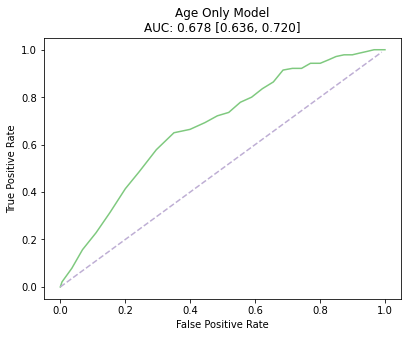

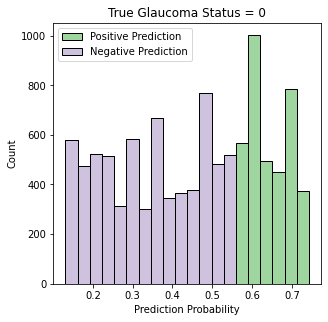

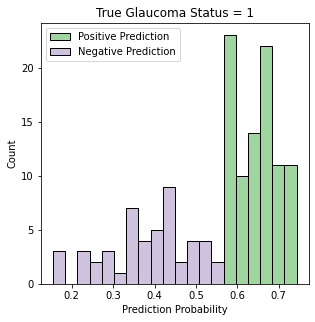

In [18]:
generate_graphs(y_test, y_test_pred_proba, 'Age Only Model')

## Model G: Genetic Data

In [19]:
model_G = load('../glaucoma_project/Models/G_alpha_0.01_hidden_layer_sizes_(100,)_AUC_0.659764315635992.joblib').best_estimator_

In [20]:
y_test_pred_proba = model_G.predict_proba(X_test[X_test.columns[243:]])

In [21]:
model_g_stats = evaluate_model(y_test, y_test_pred_proba)

AUC 0.6130496338043507
AUC CI [0.5680001  0.65809917]
Youden's J threshold 0.0147311845851681
Accuracy 0.3410757946210269
Sensitivity 0.8357142857142857
Specificity 0.3344768439108062


AUC 0.6130496338043507
AUC CI [0.5680001  0.65809917]
Youden's J threshold 0.0147311845851681
Accuracy 0.3410757946210269
Sensitivity 0.8357142857142857
Specificity 0.3344768439108062


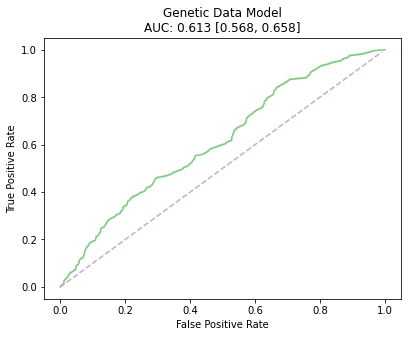

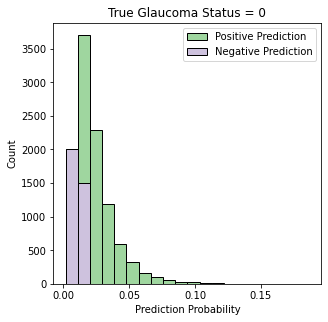

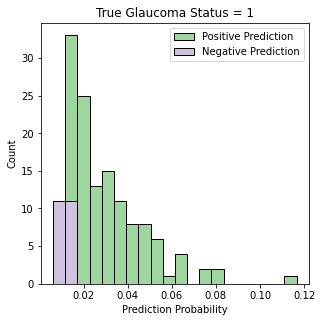

In [22]:
generate_graphs(y_test, y_test_pred_proba, 'Genetic Data Model')

## Model 1A

In [30]:
model_1a = load('../glaucoma_project/Models/1a_C_0.001_penalty_l2_solver_liblinear_AUC_0.7057715736489913.joblib').best_estimator_

In [31]:
y_test_pred_proba = model_1a.predict_proba(X_test[[col for col in classification_dict.keys() if classification_dict[col][1] == '1a']])

In [32]:
model_1a_stats = evaluate_model(y_test, y_test_pred_proba)

AUC 0.6888507718696398
AUC CI [0.64761943 0.73008211]
Youden's J threshold 0.5532074685136366
Accuracy 0.6633439909723529
Sensitivity 0.65
Specificity 0.6635220125786163


AUC 0.6888507718696398
AUC CI [0.64761943 0.73008211]
Youden's J threshold 0.5532074685136366
Accuracy 0.6633439909723529
Sensitivity 0.65
Specificity 0.6635220125786163


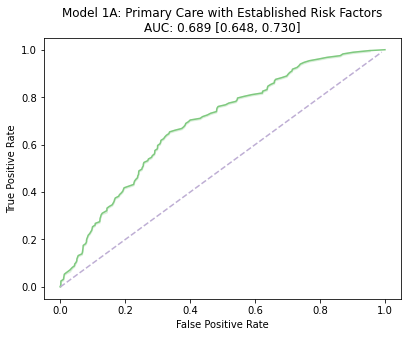

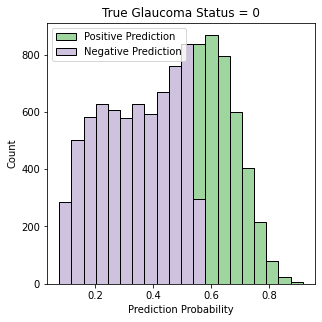

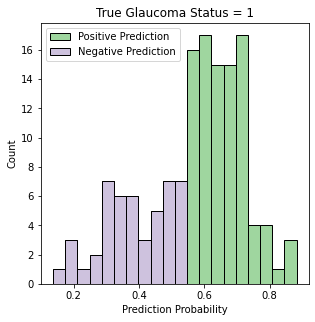

In [33]:
generate_graphs(y_test, y_test_pred_proba, 'Model 1A: Primary Care with Established Risk Factors')

## Model 1B

In [34]:
model_1b = load('../glaucoma_project/Models/1b_max_depth_1_min_samples_split_2_n_estimators_1000_AUC_0.7093904999406349.joblib').best_estimator_

In [35]:
y_test_pred_proba = model_1b.predict_proba(X_test[[col for col in classification_dict.keys() if classification_dict[col][1] in ['1a','1b']]])

In [36]:
model_1b_stats = evaluate_model(y_test, y_test_pred_proba)

AUC 0.7002307440986686
AUC CI [0.65945979 0.7410017 ]
Youden's J threshold 0.0161530444120681
Accuracy 0.6977618958059056
Sensitivity 0.6142857142857143
Specificity 0.6988755479321517


AUC 0.7002307440986686
AUC CI [0.65945979 0.7410017 ]
Youden's J threshold 0.0161530444120681
Accuracy 0.6977618958059056
Sensitivity 0.6142857142857143
Specificity 0.6988755479321517


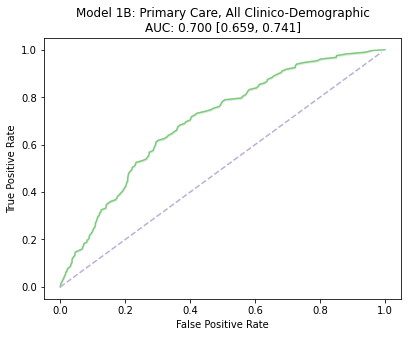

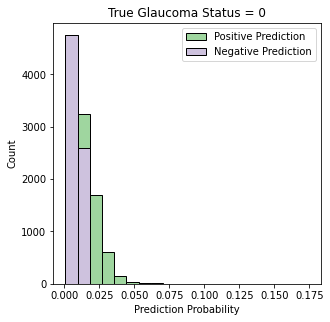

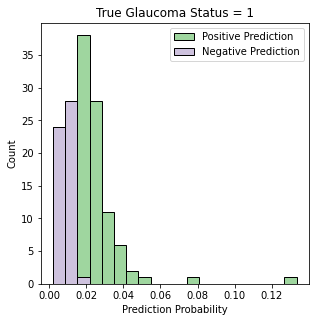

In [37]:
generate_graphs(y_test, y_test_pred_proba, 'Model 1B: Primary Care, All Clinico-Demographic')

## Model 1C

In [38]:
y_test_pred_proba_1b = model_1b.predict_proba(X_test[[col for col in classification_dict.keys() if classification_dict[col][1] in ['1a','1b']]])[:,1]

In [39]:
y_test_pred_proba_g = model_G.predict_proba(X_test[X_test.columns[243:]])[:,1]

In [40]:
meta_classifier_1c = load('../glaucoma_project/Models/meta_classifier_1c.joblib')

In [41]:
combination = np.asarray([y_test_pred_proba_1b,y_test_pred_proba_g]).T

In [42]:
y_test_pred_proba = meta_classifier_1c.predict_proba(combination)

In [43]:
model_1c_stats = evaluate_model(y_test, y_test_pred_proba)

AUC 0.7041724522856597
AUC CI [0.66412441 0.74422049]
Youden's J threshold 0.5929239531911437
Accuracy 0.5540718450253903
Sensitivity 0.7785714285714286
Specificity 0.5510768057937869


AUC 0.7041724522856597
AUC CI [0.66412441 0.74422049]
Youden's J threshold 0.5929239531911437
Accuracy 0.5540718450253903
Sensitivity 0.7785714285714286
Specificity 0.5510768057937869


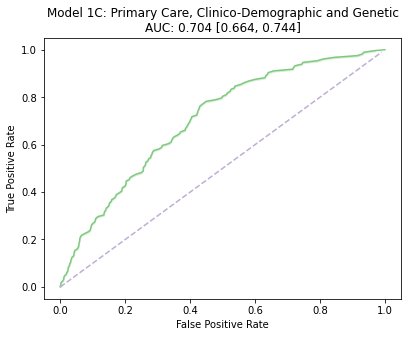

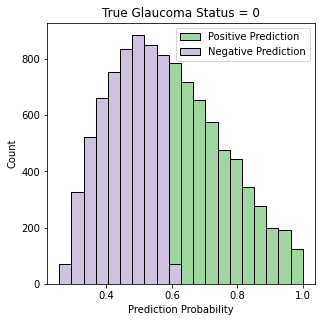

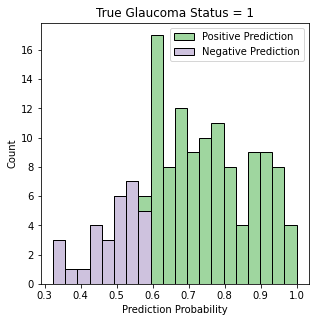

In [44]:
generate_graphs(y_test, y_test_pred_proba, 'Model 1C: Primary Care, Clinico-Demographic and Genetic')

## Model 2A

In [45]:
model_2a = load('../glaucoma_project/Models/2_max_depth_1_min_samples_split_2_n_estimators_1000_AUC_0.7370240031265742.joblib').best_estimator_

In [46]:
y_test_pred_proba = model_2a.predict_proba(X_test[[col for col in classification_dict.keys() if classification_dict[col][1] in ['1a','1b','2']]])[:,1]

In [47]:
model_2a_stats = evaluate_model(y_test, y_test_pred_proba)

AUC 0.8151031882163958
AUC CI [0.77884881 0.85135756]
Youden's J threshold 0.012660596624076882
Accuracy 0.7814557081060749
Sensitivity 0.7
Specificity 0.7825424051839146


AUC 0.8151031882163958
AUC CI [0.77884881 0.85135756]
Youden's J threshold 0.012660596624076882
Accuracy 0.7814557081060749
Sensitivity 0.7
Specificity 0.7825424051839146


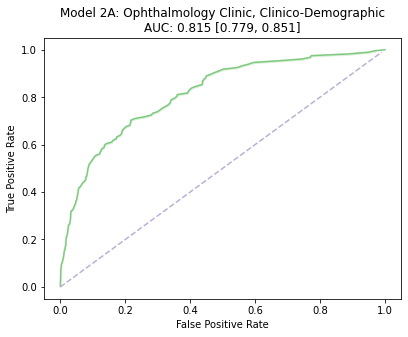

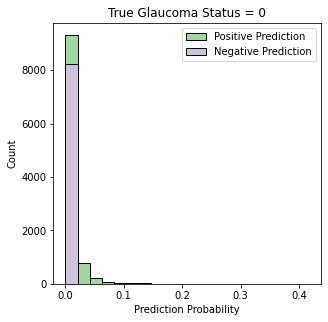

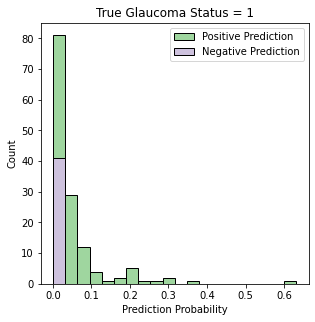

In [48]:
generate_graphs(y_test, y_test_pred_proba, 'Model 2A: Ophthalmology Clinic, Clinico-Demographic')

## Model 2B

In [104]:
meta_classifier_2b = load('../glaucoma_project/Models/meta_classifier_2b.joblib')

In [105]:
y_test_pred_proba_2a = model_2a.predict_proba(X_test[[col for col in classification_dict.keys() if classification_dict[col][1] in ['1a','1b','2']]])[:,1]

In [106]:
combination = np.asarray([y_test_pred_proba_2a,y_test_pred_proba_g]).T

In [107]:
y_test_pred_proba = meta_classifier_2b.predict_proba(combination)

In [108]:
model_2b_stats = evaluate_model(y_test, y_test_pred_proba)

AUC 0.8061218655558279
AUC CI [0.76840966 0.84383407]
Youden's J threshold 0.43350983712971597
Accuracy 0.8169080308444612
Sensitivity 0.65
Specificity 0.8191347436630455


AUC 0.8061218655558279
AUC CI [0.76840966 0.84383407]
Youden's J threshold 0.43350983712971597
Accuracy 0.8169080308444612
Sensitivity 0.65
Specificity 0.8191347436630455


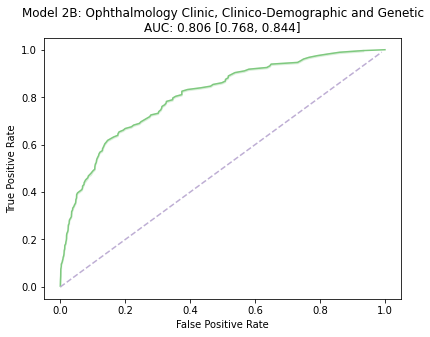

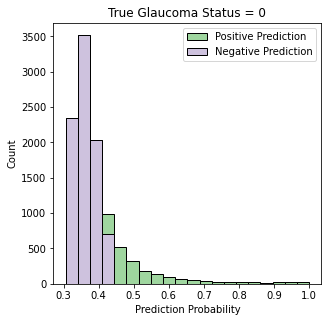

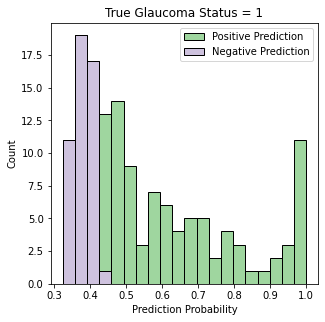

In [109]:
generate_graphs(y_test, y_test_pred_proba, 'Model 2B: Ophthalmology Clinic, Clinico-Demographic and Genetic')

## Model 3A

In [49]:
model_3a = load('../glaucoma_project/Models/3_max_depth_1_min_samples_split_2_n_estimators_1000_AUC_0.7390949435026912.joblib').best_estimator_

In [51]:
y_test_pred_proba = model_3a.predict_proba(X_test[[col for col in classification_dict.keys() if classification_dict[col][1] in ['1a','1b','2','3']]])[:,1]

In [52]:
model_3a_stats = evaluate_model(y_test, y_test_pred_proba)

AUC 0.8105781535026818
AUC CI [0.77390346 0.84725285]
Youden's J threshold 0.015382199642691595
Accuracy 0.8244310701523415
Sensitivity 0.6357142857142857
Specificity 0.82694873260911


AUC 0.8105781535026818
AUC CI [0.77390346 0.84725285]
Youden's J threshold 0.015382199642691595
Accuracy 0.8244310701523415
Sensitivity 0.6357142857142857
Specificity 0.82694873260911


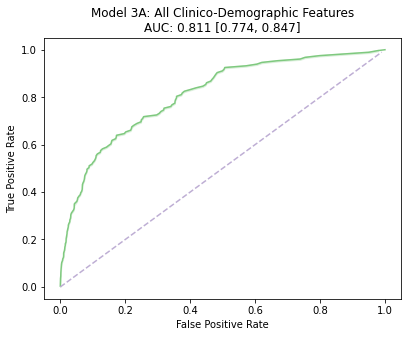

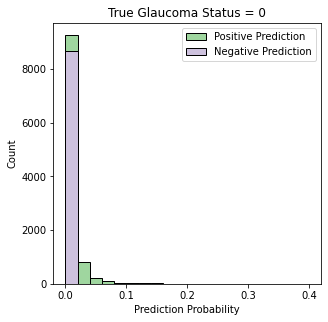

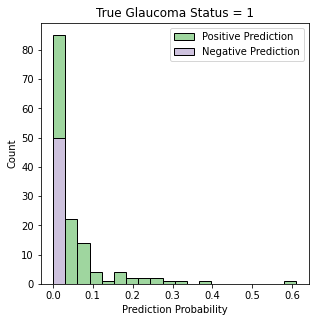

In [53]:
generate_graphs(y_test, y_test_pred_proba, 'Model 3A: All Clinico-Demographic Features')

## Model 3B

In [114]:
meta_classifier_3b = load('../glaucoma_project/Models/meta_classifier_3b.joblib')

In [115]:
y_test_pred_proba_3a = model_3a.predict_proba(X_test[[col for col in classification_dict.keys() if classification_dict[col][1] in ['1a','1b','2','3']]])[:,1]

In [116]:
combination = np.asarray([y_test_pred_proba_3a,y_test_pred_proba_g]).T

In [117]:
y_test_pred_proba = meta_classifier_3b.predict_proba(combination)

In [118]:
model_3b_stats = evaluate_model(y_test, y_test_pred_proba)

AUC 0.802156334231806
AUC CI [0.7639926  0.84032007]
Youden's J threshold 0.42397140028839675
Accuracy 0.7931164190332894
Sensitivity 0.6642857142857143
Specificity 0.7948351438917477


AUC 0.802156334231806
AUC CI [0.7639926  0.84032007]
Youden's J threshold 0.42397140028839675
Accuracy 0.7931164190332894
Sensitivity 0.6642857142857143
Specificity 0.7948351438917477


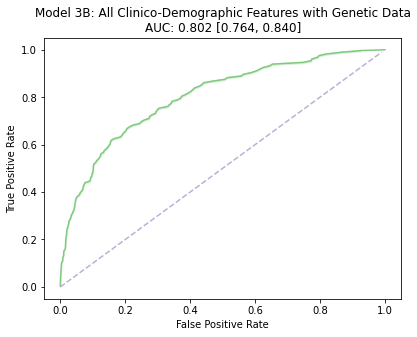

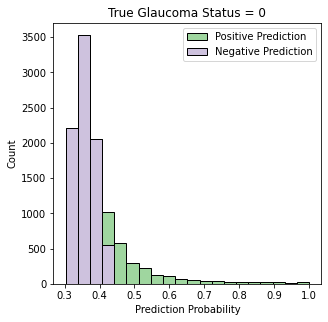

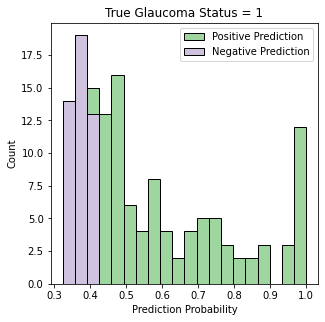

In [119]:
generate_graphs(y_test, y_test_pred_proba, 'Model 3B: All Clinico-Demographic Features with Genetic Data')

## AUC Comparisons

In [544]:
y_test_pred_proba_age = model_0.predict_proba(X_test[['Age when attended assessment centre_0']])
y_test_pred_proba_1b = model_1b.predict_proba(X_test[[col for col in classification_dict.keys() if classification_dict[col][1] in ['1a','1b']]])
permutation_test_between_clfs(y_test, y_test_pred_proba_1b[:,1], y_test_pred_proba_age[:,1])

100%|████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 170.02it/s]


(0.022331127991505273, 0.314)

# Main Results Table

In [492]:
aucs = []
thresholds = []
accs = []
sens = []
specs = []
auc_lowers = []
auc_uppers = []

In [493]:
model_names = ['Age Only', 'Genetic Only', '1A', '1B', '1C', '2A', '2B', '3A', '3B']

In [494]:
df_main_results = pd.DataFrame()
df_main_results['Model Names'] = model_names

In [495]:
for stats in age_test_stats, model_g_stats, model_1a_stats, model_1b_stats, model_1c_stats, model_2a_stats, model_2b_stats, model_3a_stats, model_3b_stats:
    aucs.append(stats[0])
    thresholds.append(stats[1])
    accs.append(stats[2])
    sens.append(stats[3])
    specs.append(stats[4])
    auc_lowers.append(stats[5][0])
    auc_uppers.append(stats[5][1])

In [496]:
df_main_results['AUROC'] = aucs
df_main_results['[0.025'] = auc_lowers
df_main_results['0.975]'] = auc_uppers
df_main_results['Accuracy'] = accs
df_main_results['Sensitivity'] = sens
df_main_results['Specificity'] = specs

In [503]:
df_main_results.round(4).to_csv('final_results_table.csv', index=False)

y_test_pred_proba# SHAP analysis

In [121]:
y_test_pred_proba

array([[0.36368929, 0.63631071],
       [0.20428737, 0.79571263],
       [0.60752496, 0.39247504],
       ...,
       [0.57011365, 0.42988635],
       [0.40181818, 0.59818182],
       [0.60436135, 0.39563865]])

In [122]:
shap_df = pd.DataFrame(np.asarray([y_test, y_test_pred_proba_3a]).T)

In [123]:
shap_df.sort_values(by=1)

,0,1
3102,0.0,0.000196
2291,0.0,0.000202
10119,0.0,0.000238
515,0.0,0.000238
7478,0.0,0.000241
...,...,...
3548,0.0,0.326439
6906,0.0,0.332128
10060,1.0,0.387178
1045,0.0,0.400079


In [54]:
import shap

In [87]:
explainer = shap.Explainer(model_3a)

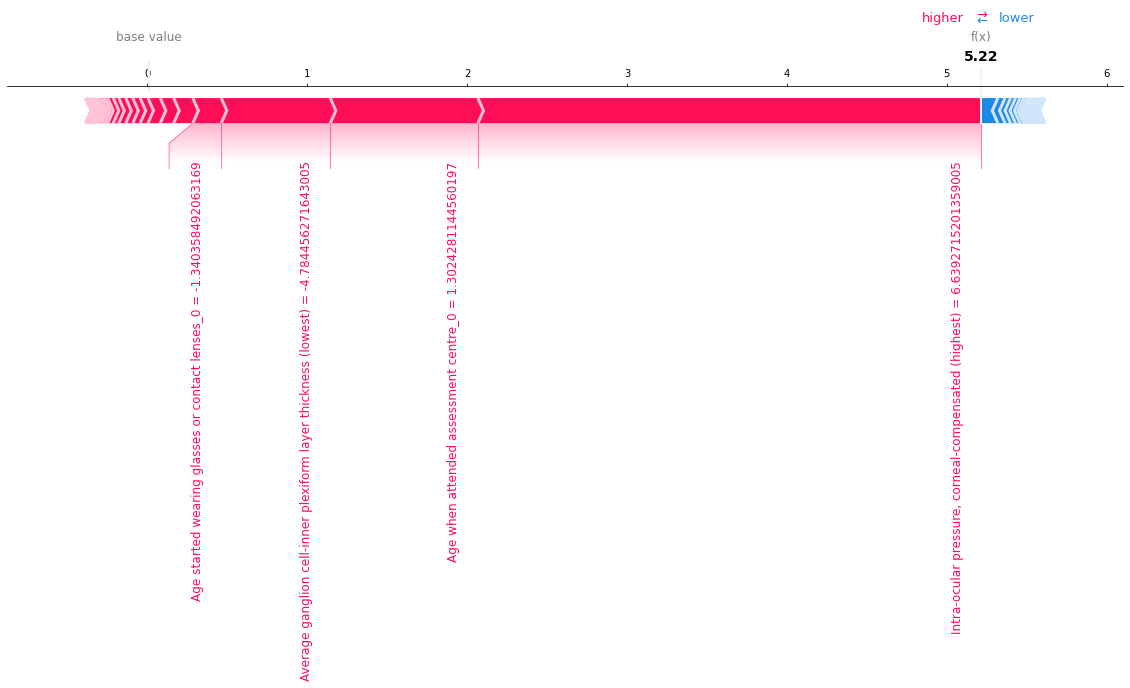

In [126]:
data_for_prediction = X_test[[col for col in classification_dict.keys() if classification_dict[col][1] in ['1a','1b','2','3']]].iloc[5222]
shap_values = explainer(data_for_prediction)
shap.force_plot(0.011295185468396581, shap_values.values, data_for_prediction, feature_names=data_for_prediction.index, text_rotation=90, matplotlib=True)

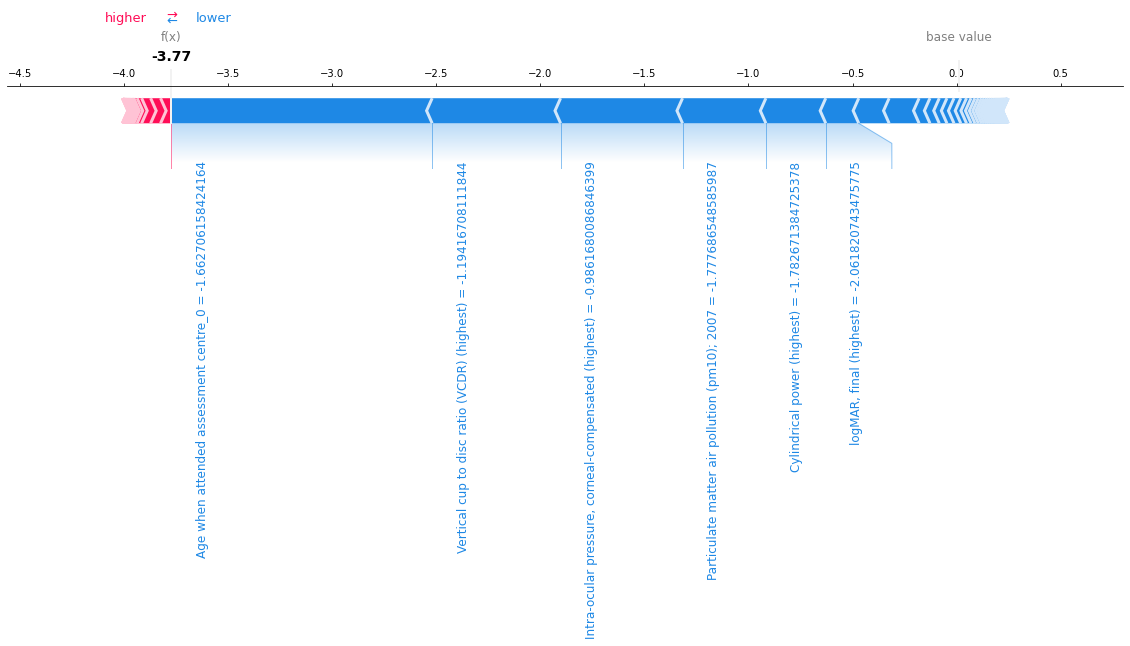

In [127]:
data_for_prediction = X_test[[col for col in classification_dict.keys() if classification_dict[col][1] in ['1a','1b','2','3']]].iloc[3102]
shap_values = explainer(data_for_prediction)
shap.force_plot(0.011295185468396581, shap_values.values, data_for_prediction, feature_names=data_for_prediction.index, text_rotation=90, matplotlib=True)

In [88]:
data_for_prediction = X_test[[col for col in classification_dict.keys() if classification_dict[col][1] in ['1a','1b','2','3']]]
explainer.expected_value = explainer.expected_value[0] 
shap_values = explainer(data_for_prediction)

In [106]:
col_names = [col for col in classification_dict.keys() if classification_dict[col][1] in ['1a','1b','2','3']]
col_names_ordered = [col_names[i] for i in np.argsort(np.mean(np.abs(shap_values.values), axis=0))]

In [108]:
col_names_ordered.reverse()

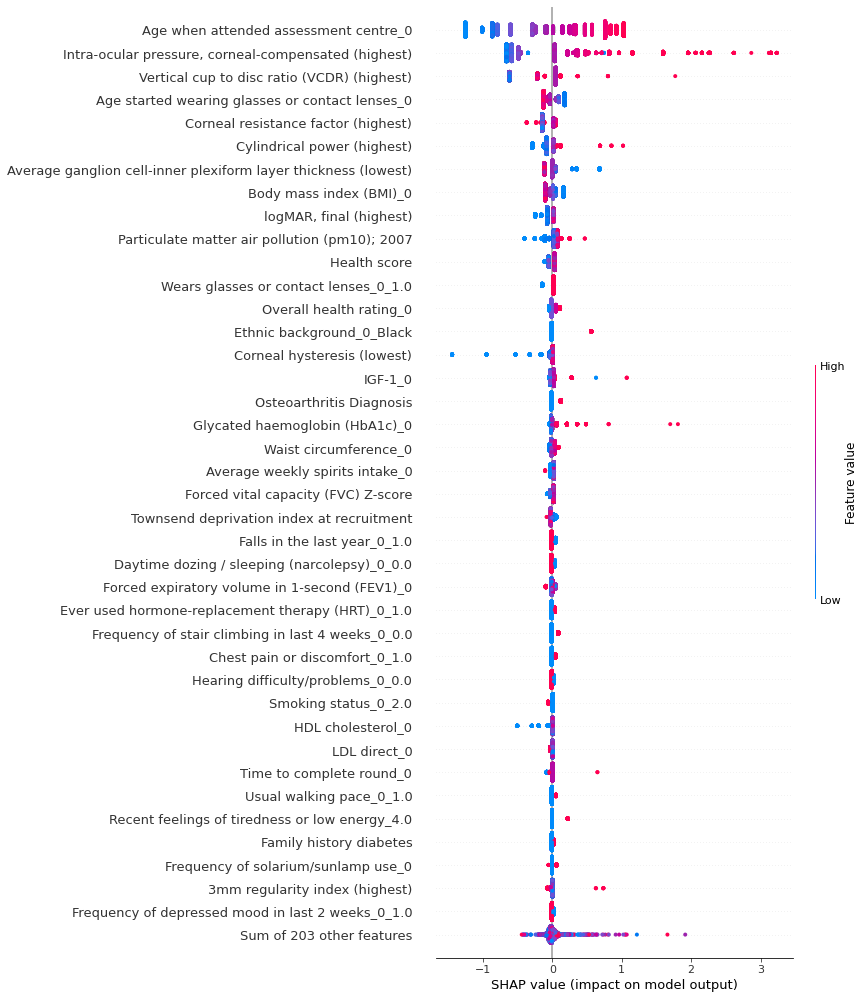

In [84]:
shap.plots.beeswarm(shap_values, max_display=40)

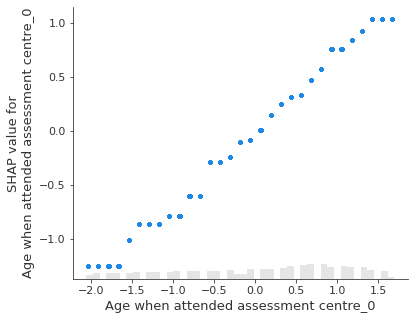

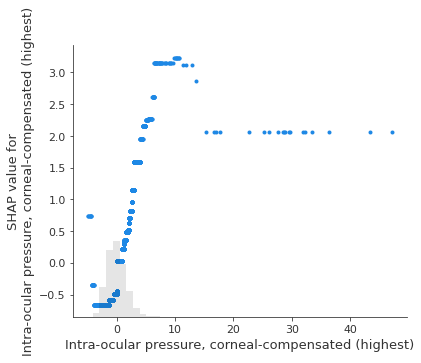

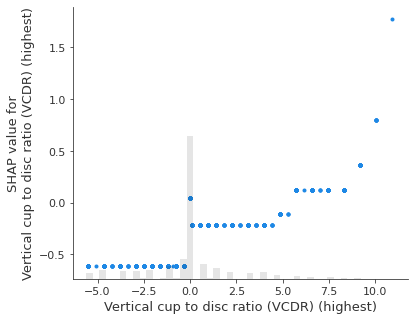

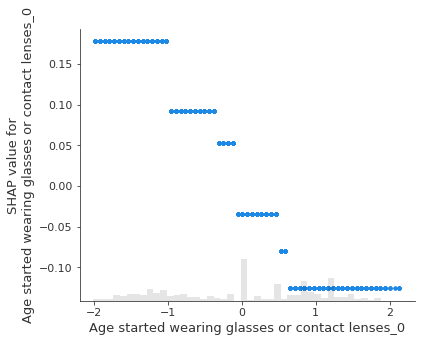

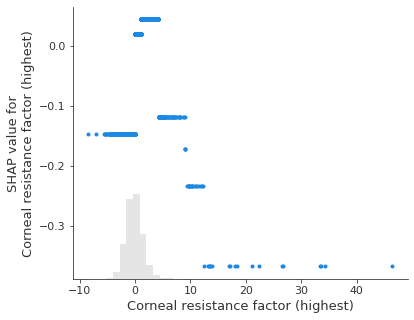

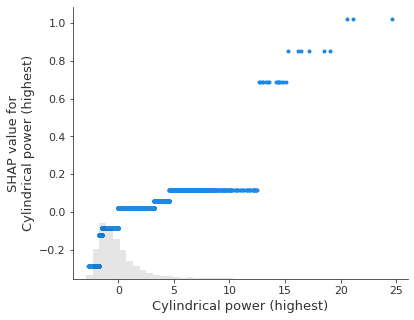

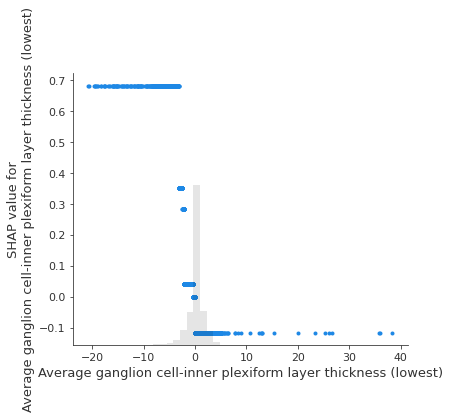

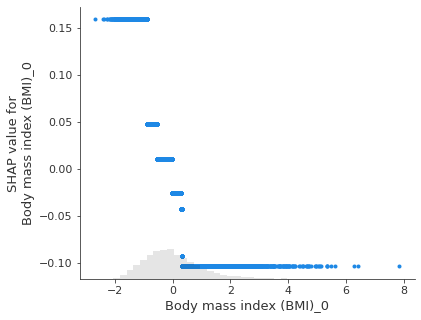

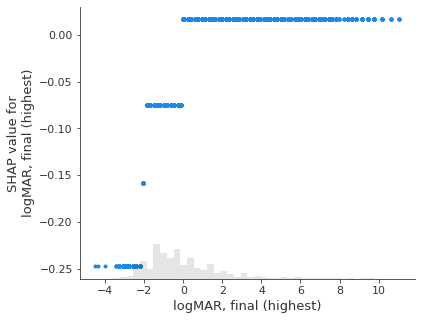

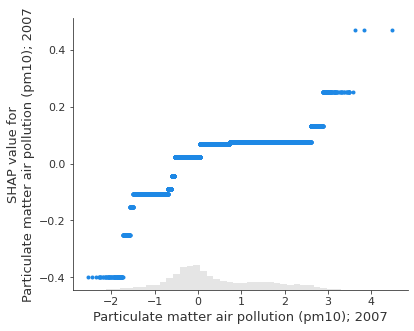

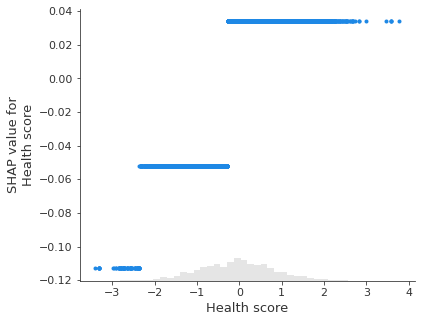

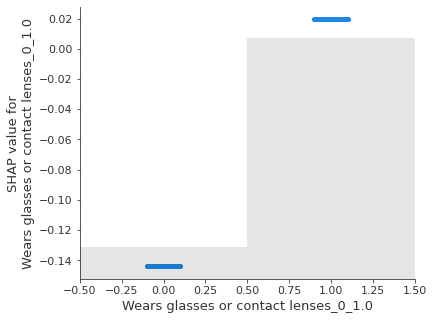

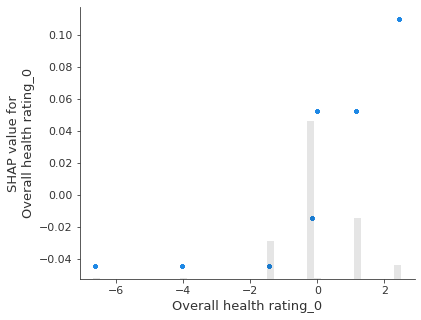

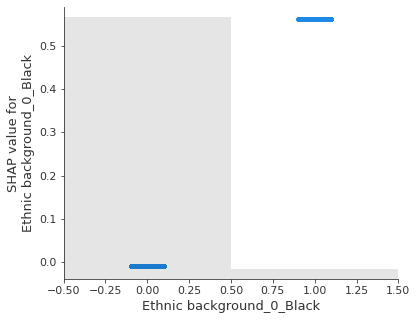

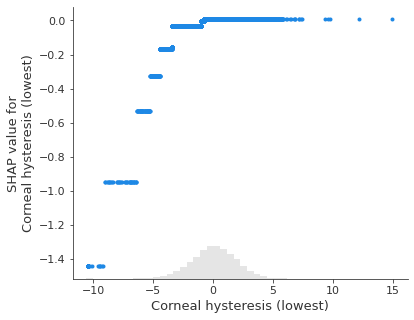

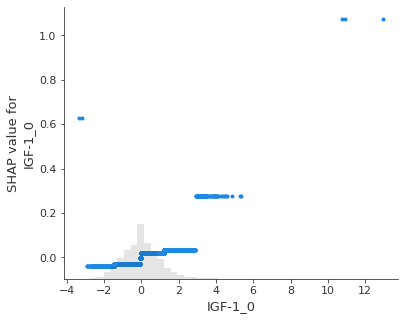

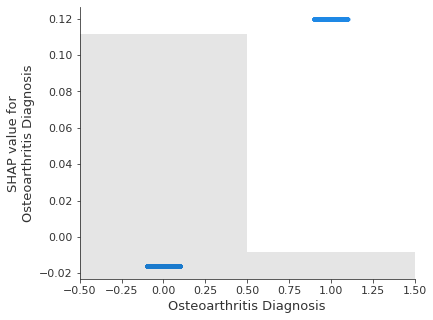

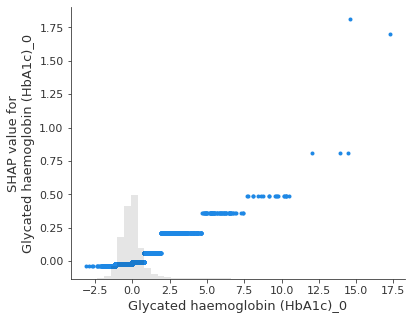

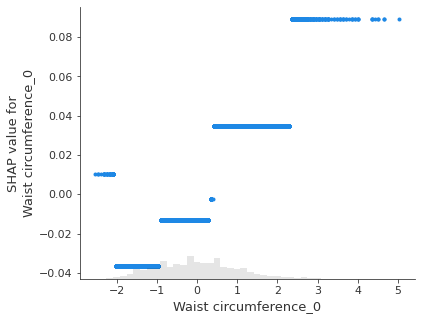

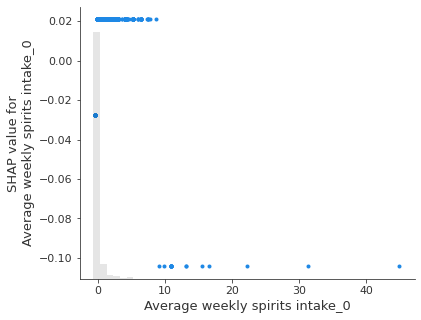

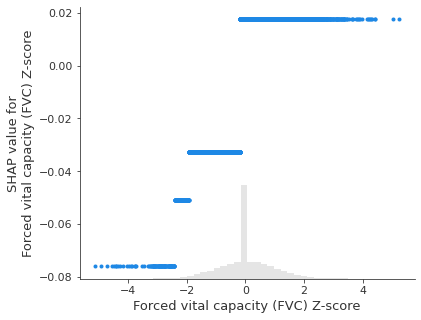

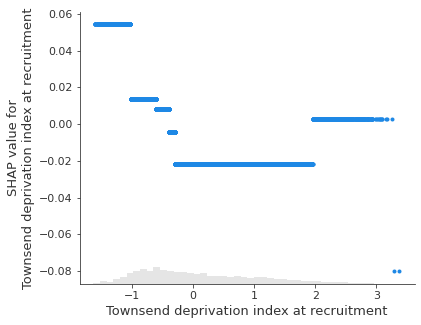

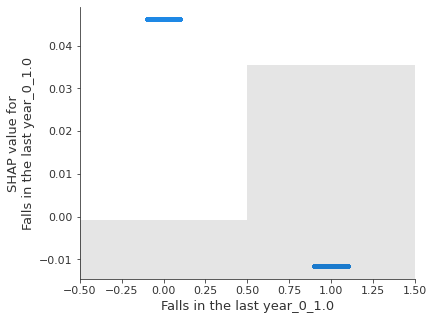

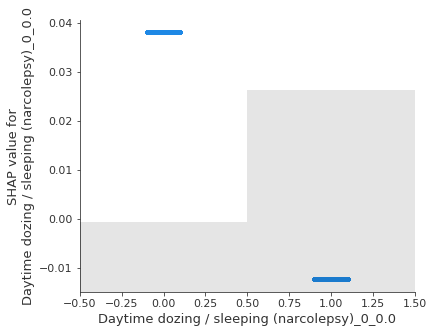

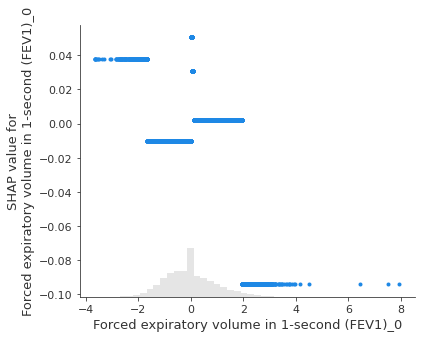

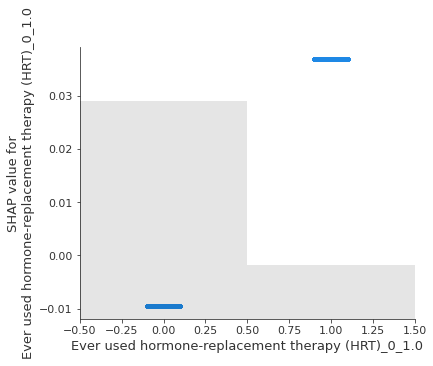

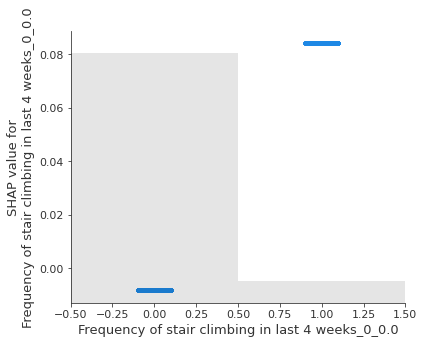

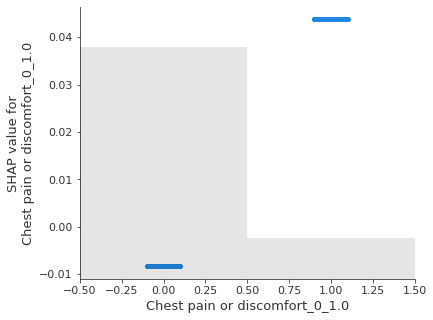

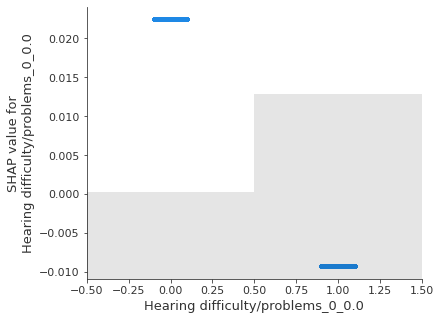

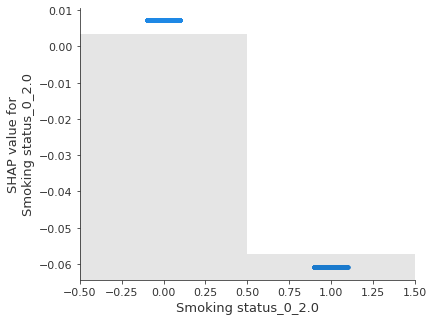

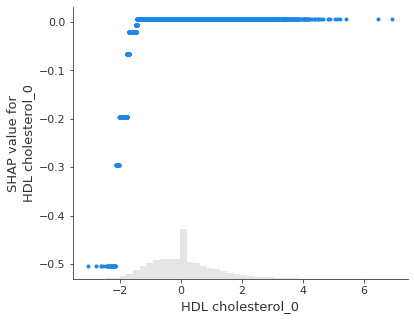

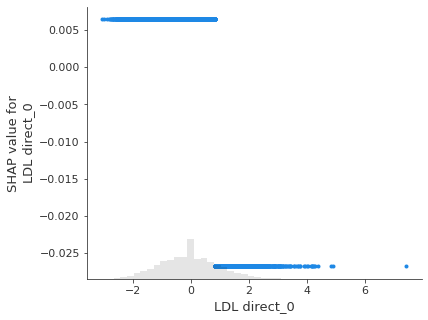

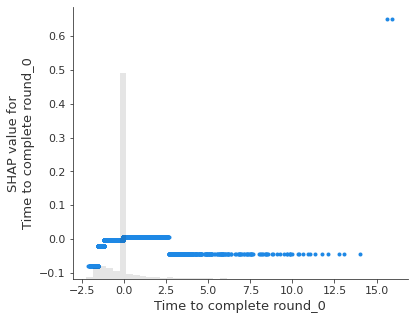

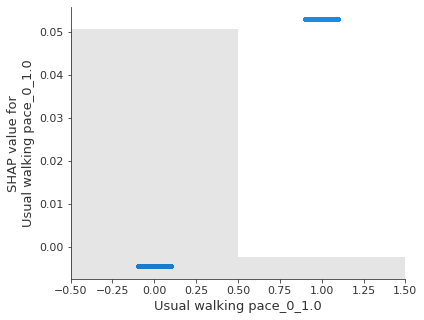

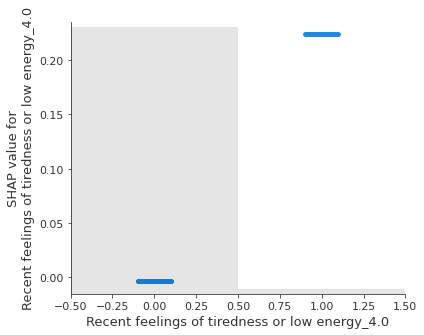

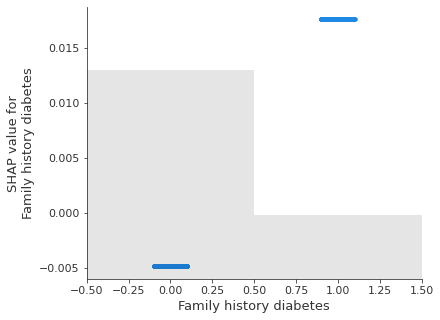

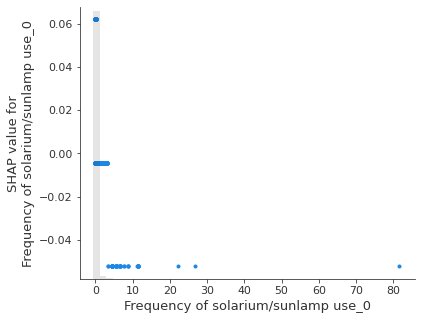

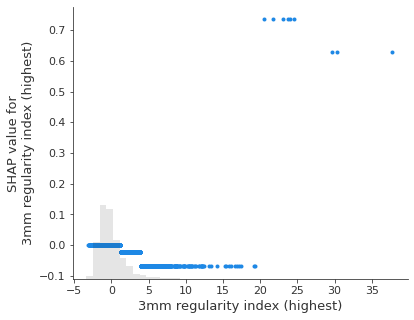

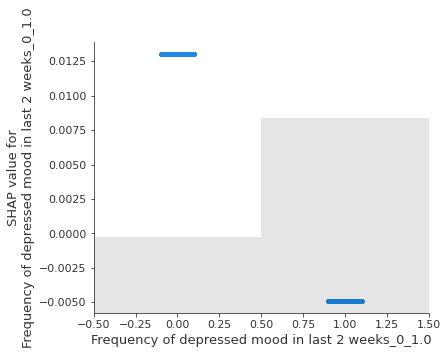

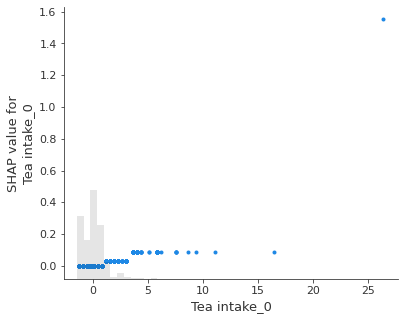

In [113]:
for col in col_names_ordered[:40]:
    shap.plots.scatter(shap_values[:,col])
    plt.show()

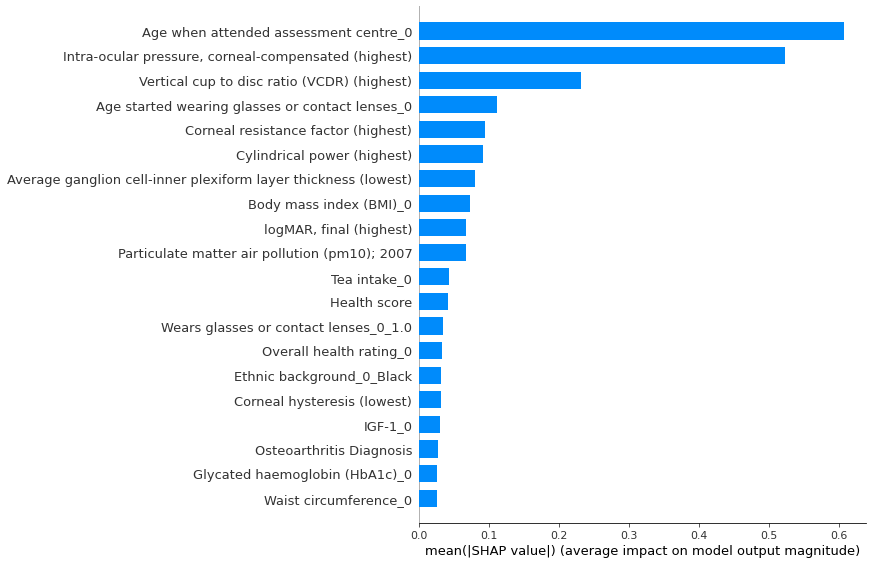

In [130]:
shap.summary_plot(shap_values, data_for_prediction, plot_type="bar")

In [131]:
data_for_prediction = X_test[X_test.columns[243:]]
shap_values = explainer(data_for_prediction)

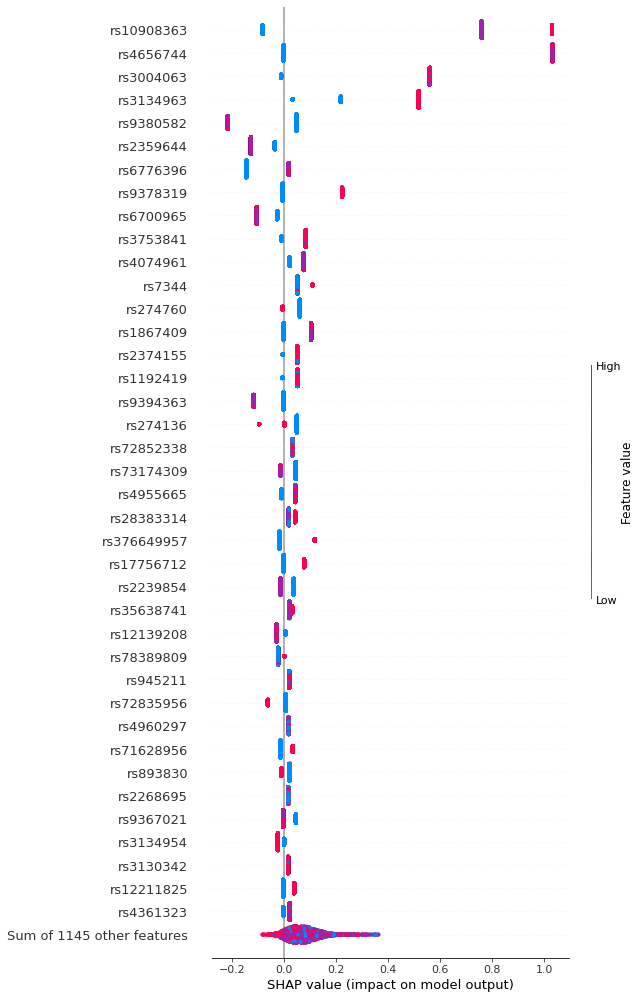

In [132]:
shap.plots.beeswarm(shap_values, max_display=40)